In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import random
import re
import spotipy
import json
import pickle
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from IPython.display import clear_output
from spotipy.oauth2 import SpotifyClientCredentials
from IPython.display import IFrame
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Import Spotify API config
import config

In [2]:
# Connecting to spotify server
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret)) 

In [3]:
# Importing dataframes
df = pd.read_csv('df.csv')

## Investigations

In [4]:
df.shape

(8460, 19)

In [5]:
df.head(3)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,playlist
0,0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,0.0276,0.0644,0.004280,0.128,0.789,120.151,audio_features,spotify:track:0ofHAoxe9vBkTCp2UQIavz,https://api.spotify.com/v1/tracks/0ofHAoxe9vBk...,https://api.spotify.com/v1/audio-analysis/0ofH...,257800,4,1970s.csv
1,2LawezPeJhN4AWuSB0GtAU,0.741,0.697,0,-7.028,1,0.0277,0.0664,0.000023,0.133,0.774,116.109,audio_features,spotify:track:2LawezPeJhN4AWuSB0GtAU,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,https://api.spotify.com/v1/audio-analysis/2Law...,160133,4,1970s.csv
2,2zYzyRzz6pRmhPzyfMEC8s,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.156,0.423,115.728,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400,4,1970s.csv


In [6]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000
mean,0.643027,0.672459,5.335816,-7.812367,0.560284,0.106943,0.203819,0.149547,0.183866,0.525371,121.581835,2.360104e+05,3.962175
std,0.170345,0.206373,3.572811,3.876357,0.496382,0.111324,0.257529,0.294335,0.147974,0.254239,26.816068,8.571518e+04,0.298931
min,0.000000,0.002850,0.000000,-41.786000,0.000000,0.000000,0.000000,0.000000,0.012500,0.000000,0.000000,1.357800e+04,0.000000
25%,0.544000,0.544000,2.000000,-9.402250,0.000000,0.038500,0.014900,0.000000,0.091900,0.327000,100.093750,1.873890e+05,4.000000
50%,0.668000,0.700000,5.000000,-7.001000,1.000000,0.056400,0.088000,0.000083,0.123000,0.536000,122.009000,2.204200e+05,4.000000
75%,0.771000,0.834000,9.000000,-5.244000,1.000000,0.123000,0.295250,0.061700,0.238000,0.734000,137.054500,2.630302e+05,4.000000
max,0.979000,1.000000,11.000000,1.634000,1.000000,0.950000,0.995000,0.985000,0.991000,0.991000,219.354000,2.245013e+06,5.000000


#### Cleaning

In [7]:
# Found that for one case, time signature of '0' was provided -> Case dropped
#df[df['time_signature'] == 0]

In [8]:
#df = df.drop(6626)

In [9]:
#df.reset_index(drop=True, inplace=True)

#### Column selection

In [10]:
# Choosing columns
df.columns

Index(['id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'playlist'],
      dtype='object')

In [11]:
# Information on audio features
'''

KEEP    acousticness(float) - Confidence that track is acoustic; 1.0: high confidence that the track is acoustic
DROP    analysis_url(string) - URL for full audio analysis
KEEP    danceability(float) - 1.0 is most danceable, 0.0 least danceable (incl. tempo, rhythm stability, beat strength, overall regularity)
????    duration_ms(int) - Length in milliseconds
KEEP    energy(float) - Perceptual measure of intensity and activity (energetic tracks: fast, loud, noisy -> Death Metal; low: Bach; incl. dynamic range, perceived loudness, timbre, onset rate, general entropy)
DROP    id(string) - Spotify ID for the track
KEEP    instrumentalness(float) - Whether a track contains no vocals prediction ("Ooh" and "aah" sounds -> instrumental; high: rap, spoken word). The closer to 1.0, the greater likelihood the track contains no vocal content; above 0.5 -> intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
DROP    key(int) - Key of the track. Integers map to pitches using standard Pitch Class notation (0 = C, 1 = C♯/D♭, 2 = D, ...). No key: -1.
KEEP    liveness(float) - Detects presence of an audience. Higher: Higher probability that track was performed live (>0.8: strong likelihood that track is live)
????    loudness(float) - Overall loudness in decibels (dB; averaged across the entire track) Values typically range between -60 and 0 db
????    mode(int) - Modality (major or minor) of a track (Maj = 1, min = 0)
KEEP    speechiness(float) - Presence of spoken words probability (speech-like: talk show, audio book, poetry -> closer to 1.0; >0.66: probably entirely of spoken words; 0.33-0.66: may contain music and speech, in sections or layered, incl. rap music; <0.33: music and other non-speech-like tracks)
KEEP    tempo(float) - Estimated tempo of a track (BPM)
????    time_signature(int) - Notational convention to specify how many beats are in each bar (or measure). Ranges: 3-7, indicating time signatures of "3/4" to "7/4".
DROP    track_href(string) - Link to Web API endpoint providing full details
DROP    type(string) - Object type
DROP    uri(string) - Spotify URI for the track.
KEEP    valence(float) - Musical positiveness conveyed by a track (high valence: sound more positive, happy, cheerful, euphoric), tracks with low valence sound more negative, sad, depressed, angry).

'''
# Keep: 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'
# ????: 'duration_ms', 'loudness', 'mode', 'time_signature'
# Drop: 'analysis_url', 'id', 'key', 'track_href', 'type', 'uri'

'\n\nKEEP    acousticness(float) - Confidence that track is acoustic; 1.0: high confidence that the track is acoustic\nDROP    analysis_url(string) - URL for full audio analysis\nKEEP    danceability(float) - 1.0 is most danceable, 0.0 least danceable (incl. tempo, rhythm stability, beat strength, overall regularity)\n????    duration_ms(int) - Length in milliseconds\nKEEP    energy(float) - Perceptual measure of intensity and activity (energetic tracks: fast, loud, noisy -> Death Metal; low: Bach; incl. dynamic range, perceived loudness, timbre, onset rate, general entropy)\nDROP    id(string) - Spotify ID for the track\nKEEP    instrumentalness(float) - Whether a track contains no vocals prediction ("Ooh" and "aah" sounds -> instrumental; high: rap, spoken word). The closer to 1.0, the greater likelihood the track contains no vocal content; above 0.5 -> intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.\nDROP    key(int) - Key of the trac

In [12]:
df.groupby(['playlist'])[['tempo', 'loudness']].agg(['mean', 'median']).head(60) # both look helpful

tempo             loudness         
                                       mean    median       mean   median
playlist                                                                 
1970s.csv                        118.917287  118.5685  -9.789747  -9.5780
1980s.csv                        118.225542  117.8085  -8.686333  -8.1880
1990s.csv                        119.366306  111.4240  -7.359806  -7.0785
2000s.csv                        115.866795  116.7140  -5.270315  -5.2300
2010s.csv                        118.663156  120.5475  -5.106438  -4.8850
2020s.csv                        117.158596  116.0320  -6.146474  -5.9340
2023_best_of.csv                 123.116392  122.0170  -6.538246  -6.1700
2023_bravohits.csv               126.527000  128.9790  -6.607978  -6.4720
2023_deutschrap.csv              126.704872  127.3410  -7.252616  -6.9475
2023_hiphop_mixtape.csv          121.882292  121.9700  -6.958215  -6.3960
2023_house_techno.csv            125.583458  124.0680  -6.161881  -5.8440
2023_tech_house.csv              126.397226  126.0165  -6.594250  -6.4040
2023_the_dome.csv                118.759350  120.4625  -7.414250  -7.4710
best_of-blues.csv                124.604638  122.6210 -11.084275 -10.8620
best_of-blues_jazz_soul.csv      120.045682  110.0490  -9.448045  -9.1200
best_of-classic.csv              100.935892   90.9490 -21.857807 -20.7300
best_of-country.csv              123.057235  122.8420  -8.870418  -7.9795
best_of_afrobeats.csv            111.878973  104.9980  -5.499540  -5.2900
best_of_britpop.csv              126.409102  120.8540  -6.995490  -6.4410
best_of_dancehall.csv            108.201584  100.2160  -5.771970  -5.4610
best_of_deep_house.csv           119.914912  120.0070  -8.743684  -8.6030
best_of_dreampop.csv             131.128340  121.2050  -9.438880  -9.0995
best_of_drill.csv                138.255150  141.9740  -7.852880  -7.4550
best_of_electro_swing.csv        122.698066  123.9990  -6.295404  -6.1980
best_of_electronic.csv           123.306173  124.5480  -5.204643  -4.9330
best_of_eurodance.csv            131.854572  130.7240  -8.393121  -7.8420
best_of_folk.csv                 114.907833  112.7955 -12.356050 -11.2645
best_of_grime.csv                117.733650  118.1660  -7.694366  -7.3880
best_of_hiphop.csv               125.234691  129.9830  -6.050404  -6.1610
best_of_house.csv                121.299465  123.4740  -6.631577  -6.4410
best_of_jazz.csv                 117.019737  116.1100 -14.915053 -14.3390
best_of_kpop.csv                 122.917091  122.0120  -3.990151  -3.8130
best_of_latin.csv                118.688516  105.0065  -5.037781  -4.6375
best_of_melodic_death_metal.csv  121.006775  115.9760  -5.075357  -4.7110
best_of_metal.csv                124.891108  124.0050  -5.361487  -4.9360
best_of_neue_deutsche_welle.csv  138.081560  134.6945 -10.086440  -9.9505
best_of_new_age.csv              108.438106  102.3995 -10.065298  -9.6195
best_of_organic_house.csv        116.526600  118.9975  -9.090580  -8.9275
best_of_pop.csv                  116.956400  116.0320  -5.936172  -5.6720
best_of_punk.csv                 131.236663  132.5260  -6.681768  -6.3210
best_of_rap.csv                  120.013284  119.9060  -6.542646  -6.1640
best_of_reggae.csv               114.547012  105.8870  -9.345802  -9.3590
best_of_reggaeton.csv            111.993571   96.0580  -5.858440  -5.6260
best_of_rnb.csv                  109.583489  100.0035  -6.059575  -5.8520
best_of_rock.csv                 123.413343  121.5250  -8.550020  -8.0845
best_of_ska.csv                  132.872901  133.2030  -6.000264  -5.6530
best_of_soul.csv                 114.735161  113.9920 -10.003304  -9.9160
best_of_soundtrack1.csv          101.399024   98.0375 -18.667854 -17.4925
best_of_soundtrack2.csv          112.233185  102.8410 -14.546315 -13.5885
best_of_synthwave.csv            122.186452  121.9770  -7.376677  -7.0120
best_of_trap.csv                 129.146903  132.0540  -7.347687  -6.5760
best_of_trip_hop.csv             117.79035

In [13]:
df.groupby(['playlist'])[['mode', 'time_signature']].agg(pd.Series.mode).head(60) 
# time signature is not that helpful, mode maybe a bit more

,mode,time_signature
playlist,,
1970s.csv,1,4
1980s.csv,1,4
1990s.csv,1,4
2000s.csv,1,4
2010s.csv,1,4
2020s.csv,1,4
2023_best_of.csv,1,4
2023_bravohits.csv,1,4
2023_deutschrap.csv,0,4


## K investigations

#### MinMaxScaler, 12 features

In [14]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness', 'mode', 'time_signature']]

In [15]:
# Check
X.shape

(8460, 12)

In [16]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'time_signature'}>]], dtype=object)

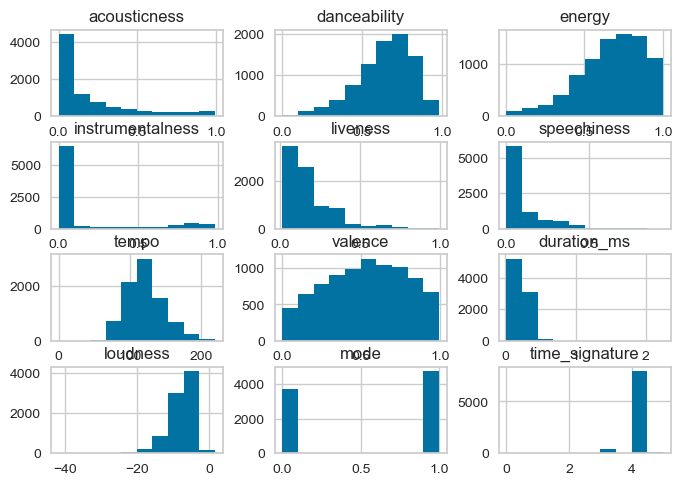

In [17]:
X.hist()

In [18]:
# Scaling model dataset (MinMaxScaler)
scaler = MinMaxScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [19]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [20]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.064724,0.845761,0.490548,0.004345,0.118038,0.029053,0.547749,0.796165,0.109446,0.737955,1.0,0.8
1,0.066734,0.756895,0.696134,0.000023,0.123148,0.029158,0.529322,0.781029,0.065677,0.800507,1.0,0.8
2,0.061307,0.586313,0.912751,0.001604,0.146653,0.140000,0.527586,0.426842,0.087308,0.851981,0.0,0.8
3,0.359799,0.554648,0.869628,0.000953,0.796627,0.045053,0.459549,0.760848,0.097167,0.812345,1.0,0.8
4,0.459296,0.538304,0.413328,0.000017,0.106796,0.128421,0.356360,0.519677,0.049975,0.698641,0.0,0.8


In [21]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000,8460.000000,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367,0.560284,3.962175
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357,0.496382,0.298931
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000,0.000000,0.000000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250,0.000000,4.000000
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000,1.000000,4.000000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000,1.000000,4.000000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000,1.000000,5.000000


Training a K-Means model with 2 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 3 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 4 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 5 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 6 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 7 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 8 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 9 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 10 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 11 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 12 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 13 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 14 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 15 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 16 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 17 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 18 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 19 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 20 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 21 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 22 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 23 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 24 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 25 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 26 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 27 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 28 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 29 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 30 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 31 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 32 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 33 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 34 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 35 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 36 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 37 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 38 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 39 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

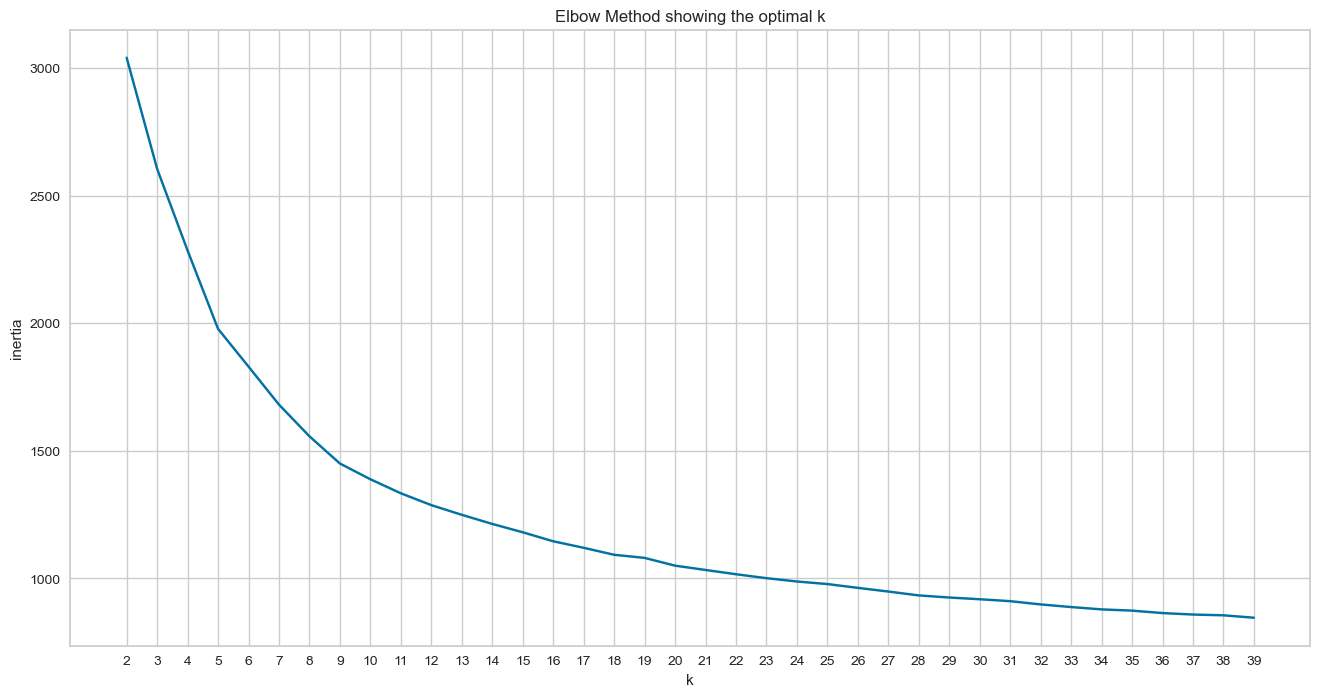

In [22]:
# Elbow investigation
K = range(2, 40)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Training a K-Means model with 2 clusters! 
Training a K-Means model with 3 clusters! 
Training a K-Means model with 4 clusters! 
Training a K-Means model with 5 clusters! 
Training a K-Means model with 6 clusters! 
Training a K-Means model with 7 clusters! 
Training a K-Means model with 8 clusters! 
Training a K-Means model with 9 clusters! 
Training a K-Means model with 10 clusters! 
Training a K-Means model with 11 clusters! 
Training a K-Means model with 12 clusters! 
Training a K-Means model with 13 clusters! 
Training a K-Means model with 14 clusters! 
Training a K-Means model with 15 clusters! 
Training a K-Means model with 16 clusters! 
Training a K-Means model with 17 clusters! 
Training a K-Means model with 18 clusters! 
Training a K-Means model with 19 clusters! 
Training a K-Means model with 20 clusters! 
Training a K-Means model with 21 clusters! 
Training a K-Means model with 22 clusters! 
Training a K-Means model with 23 clusters! 
Training a K-Means model with 24 cluster

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

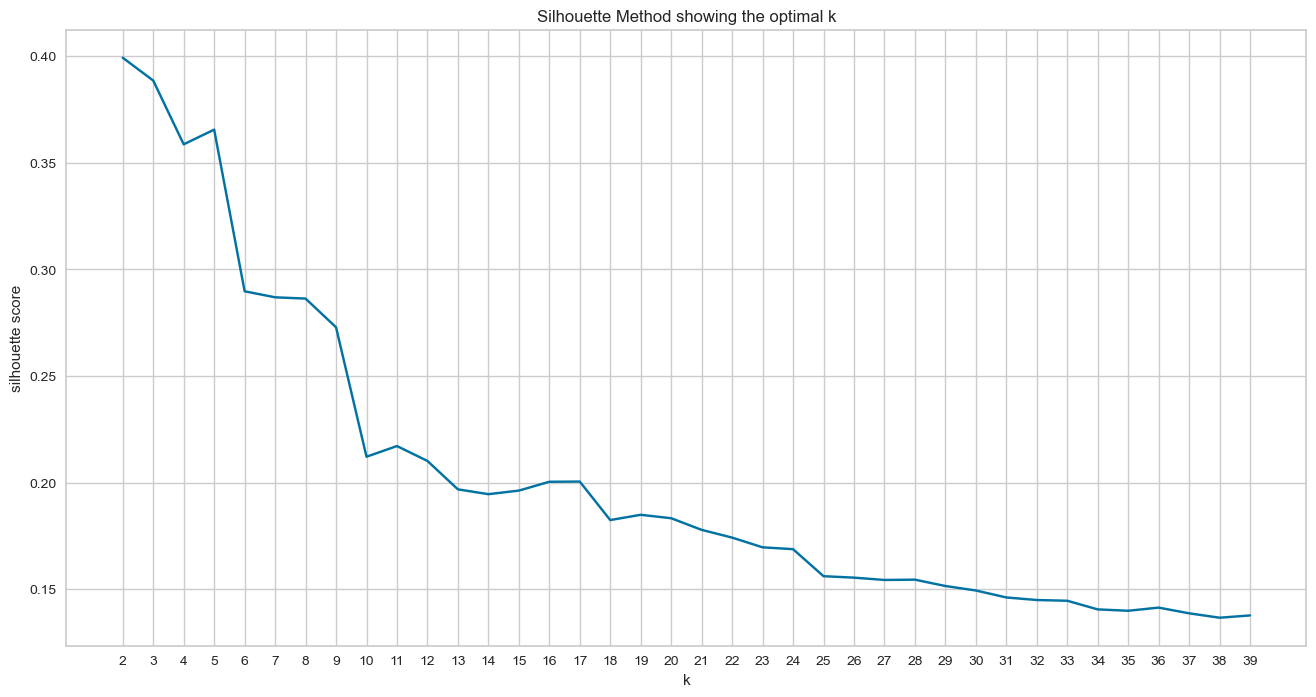

In [23]:
# Silhouette
K = range(2, 40)
silhouette = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    kmeans = KMeans(n_clusters=k,
                    random_state=42,n_init='auto')
    kmeans.fit(X_scaled)
    
    silhouette.append(silhouette_score(X_scaled, kmeans.predict(X_scaled)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

#### StandardScaler, 12 features

In [24]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness', 'mode', 'time_signature']]

In [25]:
# Check
X.shape

(8460, 12)

In [26]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'time_signature'}>]], dtype=object)

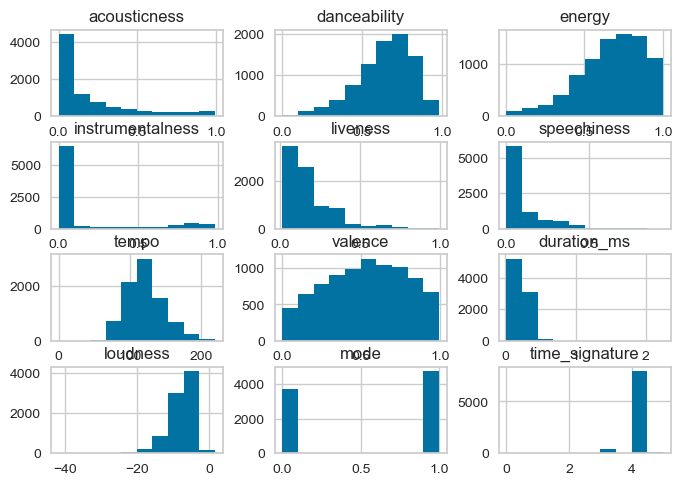

In [27]:
X.hist()

In [28]:
# Scaling model dataset (MinMaxScaler)
scaler = StandardScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [29]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [30]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,-0.541403,1.085934,-0.874484,-0.493573,-0.377564,-0.712767,-0.053361,1.036994,0.254225,-0.498341,0.885895,0.126542
1,-0.533636,0.575176,0.118923,-0.508038,-0.343772,-0.711869,-0.204100,0.977991,-0.885279,0.202359,0.885895,0.126542
2,-0.554606,-0.405244,1.165634,-0.502747,-0.188331,0.234077,-0.218309,-0.402682,-0.322136,0.778965,-1.128802,0.126542
3,0.598731,-0.587238,0.957261,-0.504925,4.109962,-0.576220,-0.774874,0.899320,-0.065457,0.334965,0.885895,0.126542
4,0.983176,-0.681171,-1.247618,-0.508057,-0.451905,0.135260,-1.619007,-0.040796,-1.294099,-0.938729,-1.128802,0.126542


In [31]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000,8460.000000,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367,0.560284,3.962175
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357,0.496382,0.298931
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000,0.000000,0.000000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250,0.000000,4.000000
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000,1.000000,4.000000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000,1.000000,4.000000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000,1.000000,5.000000


Training a K-Means model with 2 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 3 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 4 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 5 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 6 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 7 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 8 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 9 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 10 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 11 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 12 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 13 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 14 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 15 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 16 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 17 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 18 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 19 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 20 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 21 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 22 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 23 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 24 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 25 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 26 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 27 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 28 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 29 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 30 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 31 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 32 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 33 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 34 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 35 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 36 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 37 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 38 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 39 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

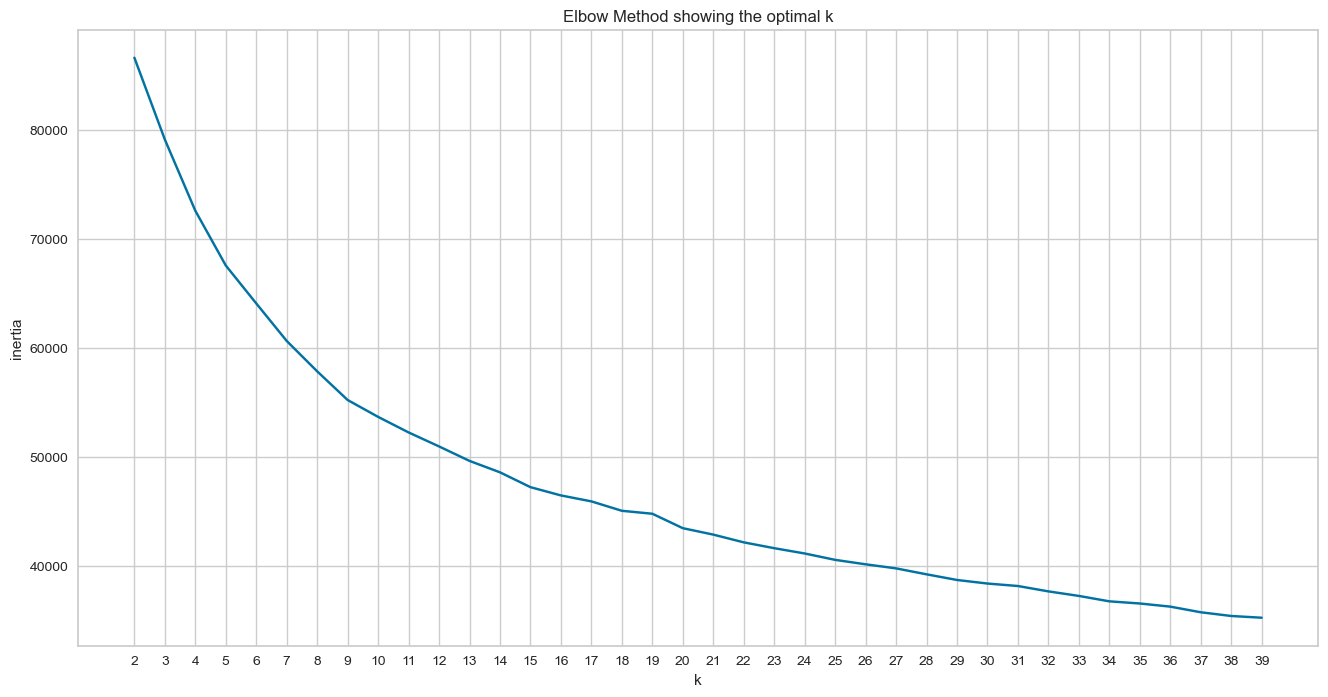

In [32]:
# Elbow investigation
K = range(2, 40)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Training a K-Means model with 2 clusters! 
Training a K-Means model with 3 clusters! 
Training a K-Means model with 4 clusters! 
Training a K-Means model with 5 clusters! 
Training a K-Means model with 6 clusters! 
Training a K-Means model with 7 clusters! 
Training a K-Means model with 8 clusters! 
Training a K-Means model with 9 clusters! 
Training a K-Means model with 10 clusters! 
Training a K-Means model with 11 clusters! 
Training a K-Means model with 12 clusters! 
Training a K-Means model with 13 clusters! 
Training a K-Means model with 14 clusters! 
Training a K-Means model with 15 clusters! 
Training a K-Means model with 16 clusters! 
Training a K-Means model with 17 clusters! 
Training a K-Means model with 18 clusters! 
Training a K-Means model with 19 clusters! 
Training a K-Means model with 20 clusters! 
Training a K-Means model with 21 clusters! 
Training a K-Means model with 22 clusters! 
Training a K-Means model with 23 clusters! 
Training a K-Means model with 24 cluster

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

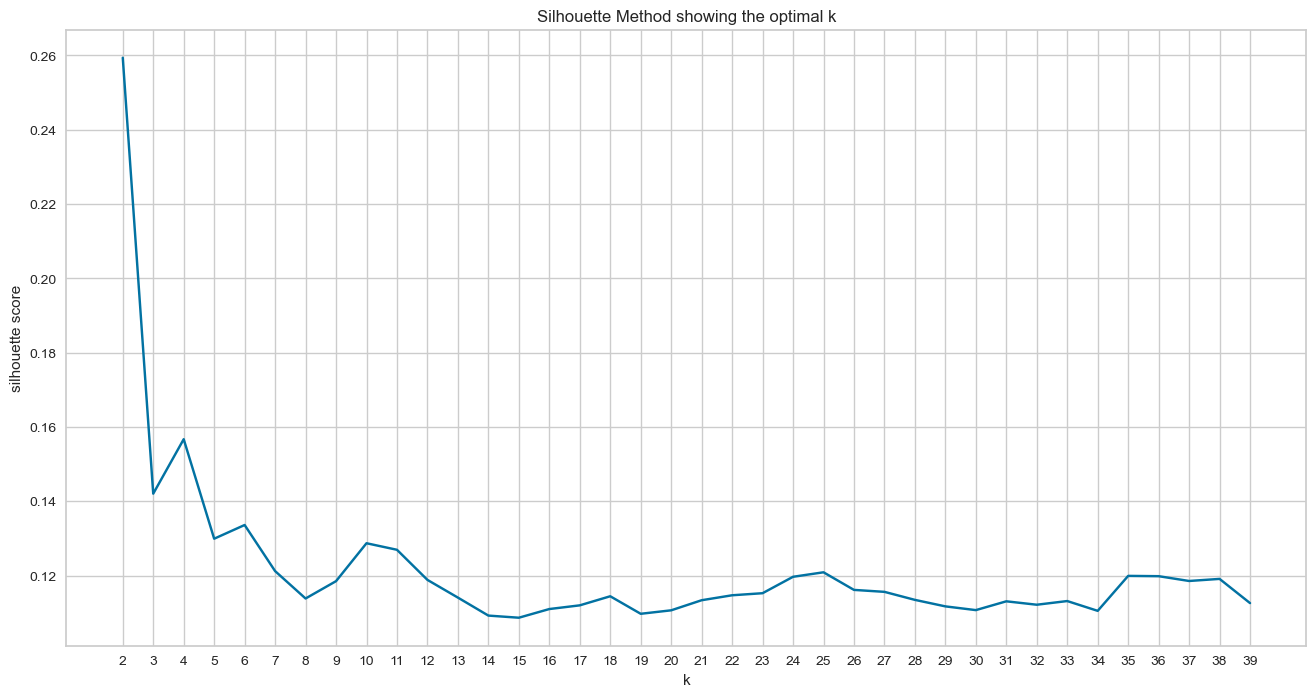

In [33]:
# Silhouette
K = range(2, 40)
silhouette = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    kmeans = KMeans(n_clusters=k,
                    random_state=42,n_init='auto')
    kmeans.fit(X_scaled)
    
    silhouette.append(silhouette_score(X_scaled, kmeans.predict(X_scaled)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

#### MinMaxScaler, 10 features

In [34]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness']]

In [35]:
# Check
X.shape

(8460, 10)

In [36]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451
...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>, <Axes: >, <Axes: >]],
      dtype=object)

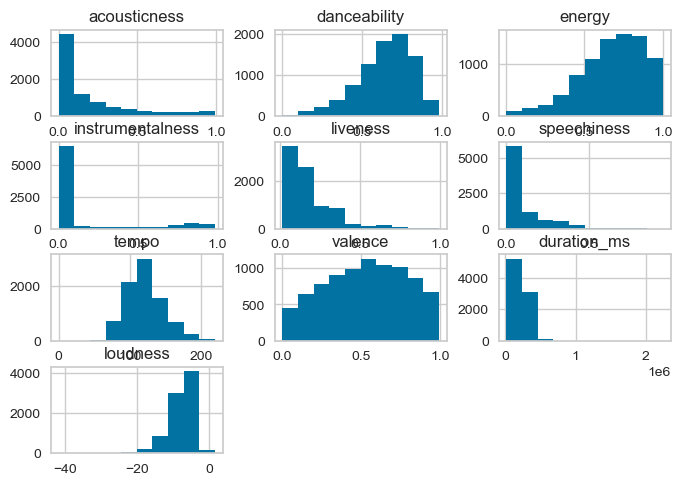

In [37]:
X.hist()

In [38]:
# Scaling model dataset (MinMaxScaler)
scaler = MinMaxScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [39]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [40]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
0,0.064724,0.845761,0.490548,0.004345,0.118038,0.029053,0.547749,0.796165,0.109446,0.737955
1,0.066734,0.756895,0.696134,0.000023,0.123148,0.029158,0.529322,0.781029,0.065677,0.800507
2,0.061307,0.586313,0.912751,0.001604,0.146653,0.140000,0.527586,0.426842,0.087308,0.851981
3,0.359799,0.554648,0.869628,0.000953,0.796627,0.045053,0.459549,0.760848,0.097167,0.812345
4,0.459296,0.538304,0.413328,0.000017,0.106796,0.128421,0.356360,0.519677,0.049975,0.698641


In [41]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000


Training a K-Means model with 2 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 3 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 4 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 5 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 6 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 7 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 8 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 9 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 10 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 11 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 12 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 13 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 14 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 15 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 16 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 17 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 18 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 19 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 20 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 21 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 22 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 23 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 24 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 25 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 26 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 27 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 28 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 29 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 30 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 31 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 32 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 33 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 34 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 35 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 36 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 37 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 38 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 39 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 40 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

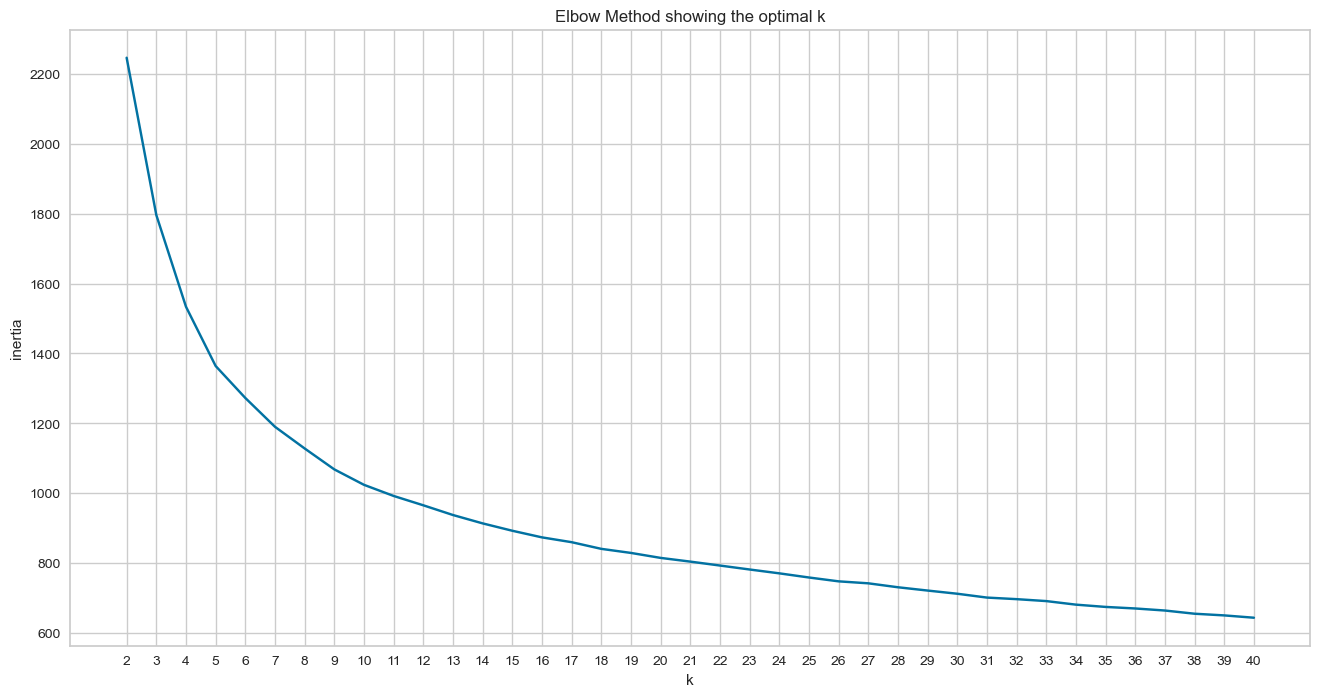

In [42]:
# Elbow investigation
K = range(2, 41)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Training a K-Means model with 2 clusters! 
Training a K-Means model with 3 clusters! 
Training a K-Means model with 4 clusters! 
Training a K-Means model with 5 clusters! 
Training a K-Means model with 6 clusters! 
Training a K-Means model with 7 clusters! 
Training a K-Means model with 8 clusters! 
Training a K-Means model with 9 clusters! 
Training a K-Means model with 10 clusters! 
Training a K-Means model with 11 clusters! 
Training a K-Means model with 12 clusters! 
Training a K-Means model with 13 clusters! 
Training a K-Means model with 14 clusters! 
Training a K-Means model with 15 clusters! 
Training a K-Means model with 16 clusters! 
Training a K-Means model with 17 clusters! 
Training a K-Means model with 18 clusters! 
Training a K-Means model with 19 clusters! 
Training a K-Means model with 20 clusters! 
Training a K-Means model with 21 clusters! 
Training a K-Means model with 22 clusters! 
Training a K-Means model with 23 clusters! 
Training a K-Means model with 24 cluster

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

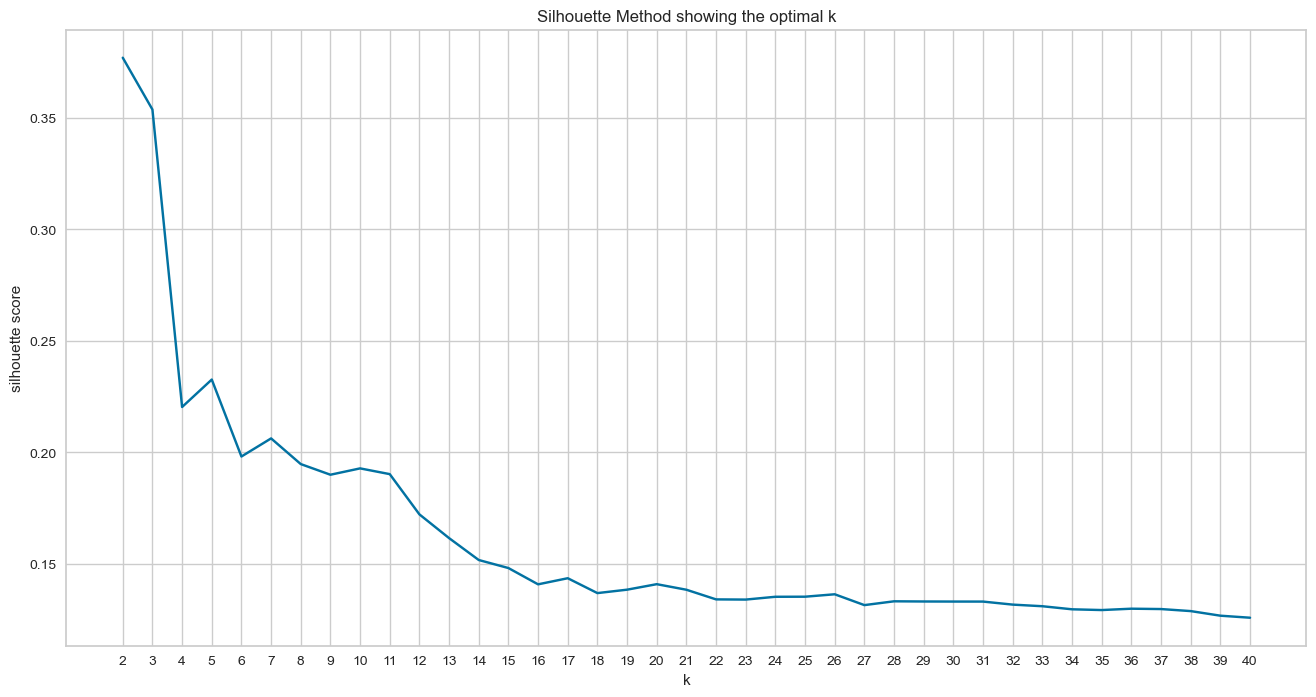

In [43]:
# Silhouette
K = range(2, 41)
silhouette = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    kmeans = KMeans(n_clusters=k,
                    random_state=42,n_init='auto')
    kmeans.fit(X_scaled)
    
    silhouette.append(silhouette_score(X_scaled, kmeans.predict(X_scaled)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

#### StandardScaler, 10 features

In [44]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness']]

In [45]:
# Check
X.shape

(8460, 10)

In [46]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451
...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>, <Axes: >, <Axes: >]],
      dtype=object)

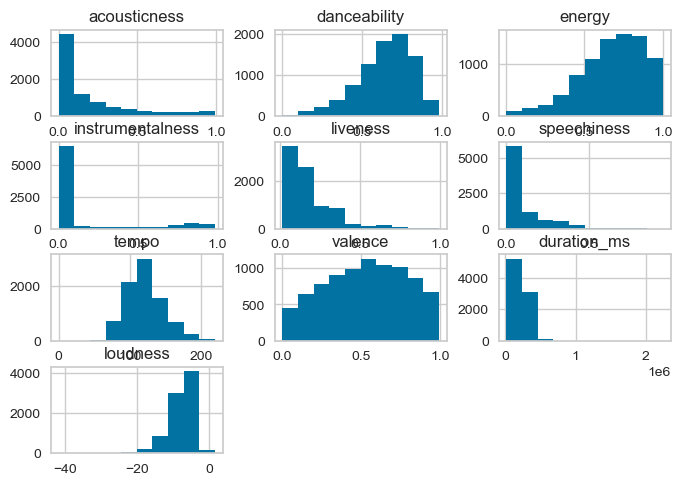

In [47]:
X.hist()

In [48]:
# Scaling model dataset (MinMaxScaler)
scaler = StandardScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [49]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [50]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
0,-0.541403,1.085934,-0.874484,-0.493573,-0.377564,-0.712767,-0.053361,1.036994,0.254225,-0.498341
1,-0.533636,0.575176,0.118923,-0.508038,-0.343772,-0.711869,-0.204100,0.977991,-0.885279,0.202359
2,-0.554606,-0.405244,1.165634,-0.502747,-0.188331,0.234077,-0.218309,-0.402682,-0.322136,0.778965
3,0.598731,-0.587238,0.957261,-0.504925,4.109962,-0.576220,-0.774874,0.899320,-0.065457,0.334965
4,0.983176,-0.681171,-1.247618,-0.508057,-0.451905,0.135260,-1.619007,-0.040796,-1.294099,-0.938729


In [51]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000


Training a K-Means model with 2 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 3 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 4 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 5 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 6 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 7 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 8 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 9 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 10 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 11 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 12 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 13 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 14 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 15 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 16 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 17 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 18 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 19 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 20 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 21 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 22 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 23 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 24 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 25 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 26 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 27 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 28 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 29 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 30 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 31 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 32 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 33 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 34 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 35 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 36 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 37 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 38 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 39 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training a K-Means model with 40 clusters! 



D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

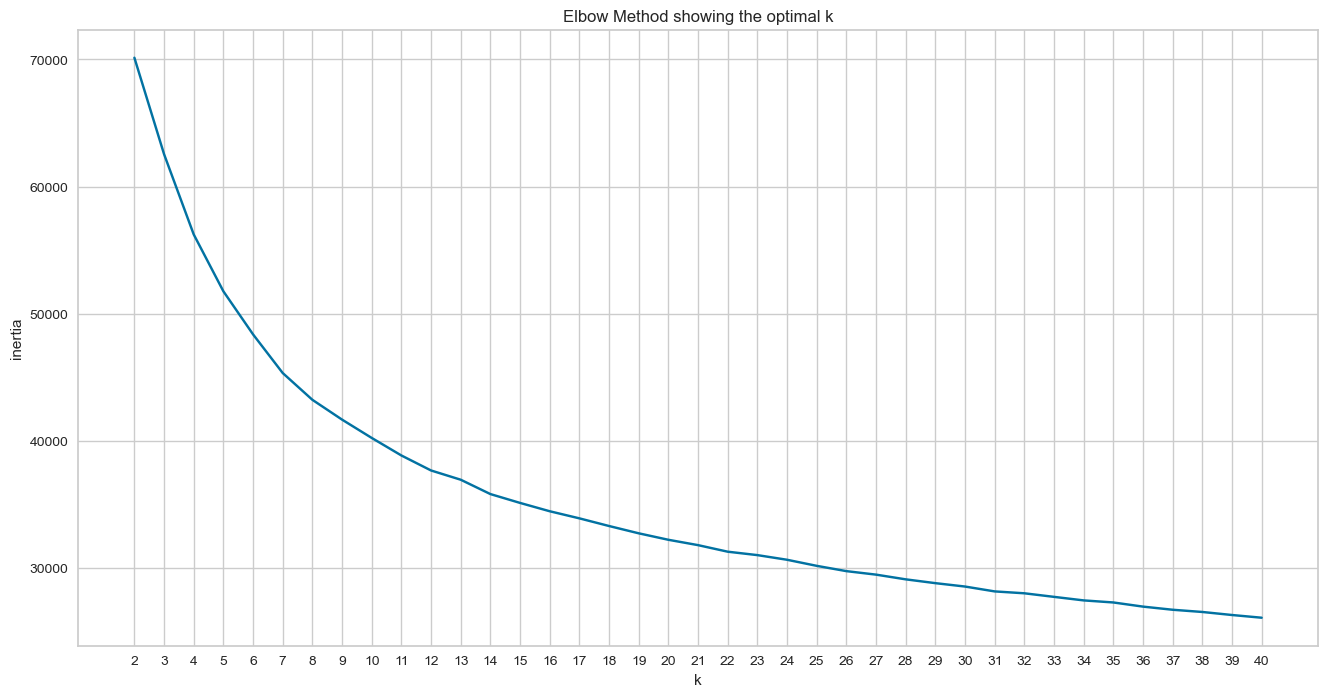

In [52]:
# Elbow investigation
K = range(2, 41)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Training a K-Means model with 2 clusters! 
Training a K-Means model with 3 clusters! 
Training a K-Means model with 4 clusters! 
Training a K-Means model with 5 clusters! 
Training a K-Means model with 6 clusters! 
Training a K-Means model with 7 clusters! 
Training a K-Means model with 8 clusters! 
Training a K-Means model with 9 clusters! 
Training a K-Means model with 10 clusters! 
Training a K-Means model with 11 clusters! 
Training a K-Means model with 12 clusters! 
Training a K-Means model with 13 clusters! 
Training a K-Means model with 14 clusters! 
Training a K-Means model with 15 clusters! 
Training a K-Means model with 16 clusters! 
Training a K-Means model with 17 clusters! 
Training a K-Means model with 18 clusters! 
Training a K-Means model with 19 clusters! 
Training a K-Means model with 20 clusters! 
Training a K-Means model with 21 clusters! 
Training a K-Means model with 22 clusters! 
Training a K-Means model with 23 clusters! 
Training a K-Means model with 24 cluster

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

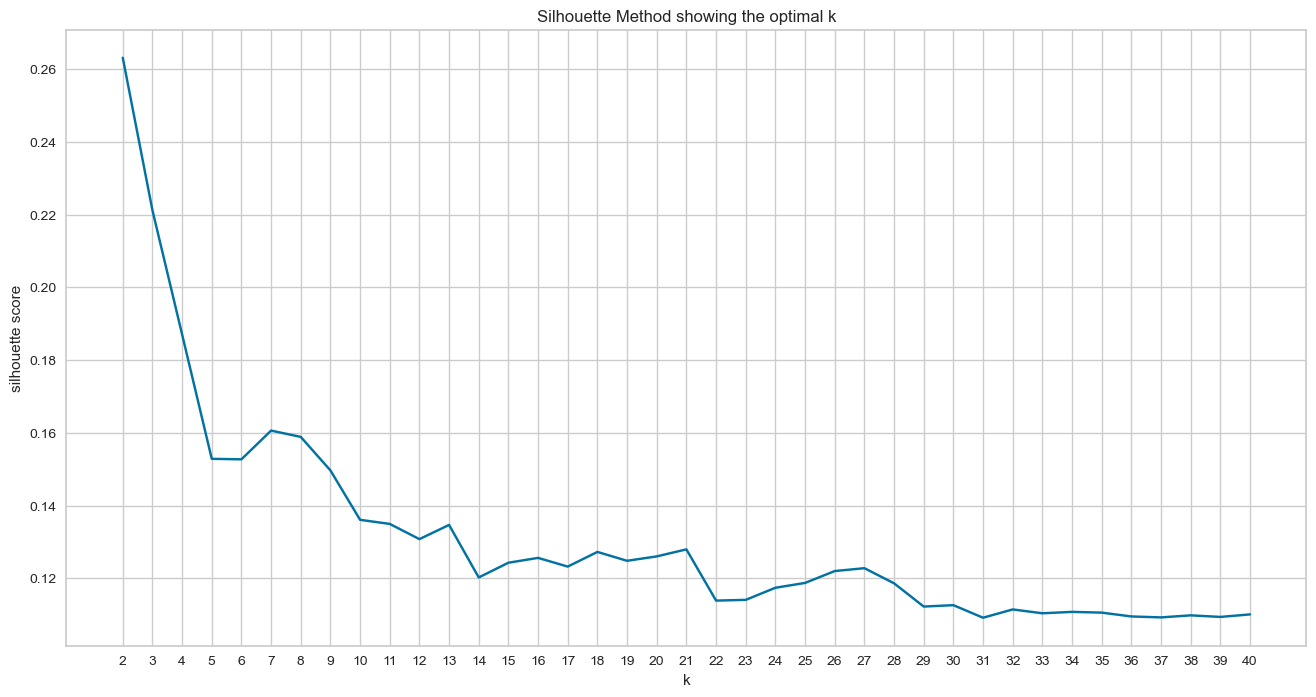

In [53]:
# Silhouette
K = range(2, 41)
silhouette = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    kmeans = KMeans(n_clusters=k,
                    random_state=42,n_init='auto')
    kmeans.fit(X_scaled)
    
    silhouette.append(silhouette_score(X_scaled, kmeans.predict(X_scaled)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

## Model 1: Basic clustering model (12 fixed clusters, 12 features, MinMax scaling)

#### Preparations & specifications

In [54]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness', 'mode', 'time_signature']]

In [55]:
# Check
X.shape

(8460, 12)

In [56]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'time_signature'}>]], dtype=object)

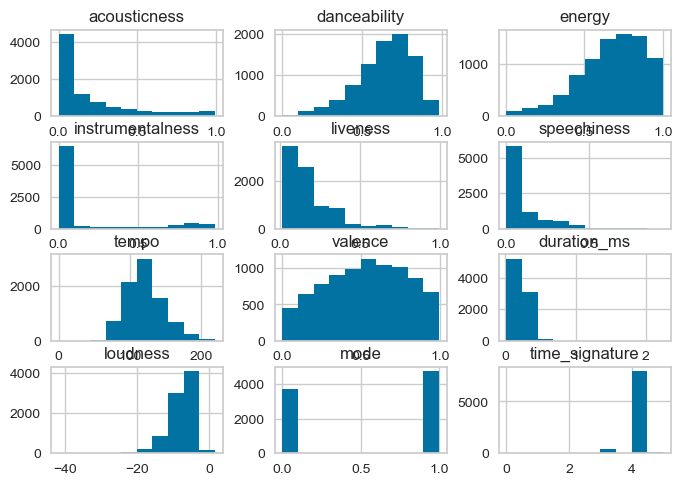

In [57]:
X.hist()

In [58]:
# Scaling model dataset (MinMaxScaler)
scaler = MinMaxScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [59]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [60]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.064724,0.845761,0.490548,0.004345,0.118038,0.029053,0.547749,0.796165,0.109446,0.737955,1.0,0.8
1,0.066734,0.756895,0.696134,0.000023,0.123148,0.029158,0.529322,0.781029,0.065677,0.800507,1.0,0.8
2,0.061307,0.586313,0.912751,0.001604,0.146653,0.140000,0.527586,0.426842,0.087308,0.851981,0.0,0.8
3,0.359799,0.554648,0.869628,0.000953,0.796627,0.045053,0.459549,0.760848,0.097167,0.812345,1.0,0.8
4,0.459296,0.538304,0.413328,0.000017,0.106796,0.128421,0.356360,0.519677,0.049975,0.698641,0.0,0.8


In [61]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000,8460.000000,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367,0.560284,3.962175
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357,0.496382,0.298931
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000,0.000000,0.000000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250,0.000000,4.000000
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000,1.000000,4.000000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000,1.000000,4.000000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000,1.000000,5.000000


#### Model building

In [62]:
# Clustering
kmeans = KMeans(n_clusters=12, random_state=42)
kmeans.fit(X_scaled)

D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=12, random_state=42)

In [63]:
# Checking result
labels = kmeans.labels_
print(labels)
print(np.unique(labels))
print(len(labels))

[3 3 7 ... 6 7 6]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
8460


In [64]:
# Predict
clusters = kmeans.predict(X_scaled)

# Check
clusters

array([3, 3, 7, ..., 6, 7, 6])

In [65]:
# Check: Counts per cluster
pd.Series(clusters).value_counts().sort_index()

0      935
1     1456
2      452
3     1290
4      763
5      126
6      527
7     1118
8      595
9      493
10     544
11     161
Name: count, dtype: int64

In [66]:
# Adding clusters to model and original dataframe
X['cluster'] = clusters
df["cluster"] = clusters

C:\Users\user\AppData\Local\Temp\ipykernel_8408\1697861218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


In [67]:
# Adding ID to model df
X['id'] = df['id']

C:\Users\user\AppData\Local\Temp\ipykernel_8408\2796432165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['id'] = df['id']


In [68]:
# Check (should be: 14, 20)
print(X.shape)
print(df.shape)

(8460, 14)
(8460, 20)


In [69]:
# Re-order
X = X[['id', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature', 'cluster']]

In [70]:
X

,id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4,3
1,2LawezPeJhN4AWuSB0GtAU,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4,3
2,2zYzyRzz6pRmhPzyfMEC8s,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4,7
3,0GjEhVFGZW8afUYGChu3Rr,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4,4
4,1k1Bqnv2R0uJXQN4u6LKYt,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8455,5lKpoFNmC76ZZzbdskA1um,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4,5
8456,0jv2rlqUHawLg2MRVf6ucQ,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4,8
8457,4ZUGwm85RzlaD8WLQsC0Ru,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4,6
8458,6jINk60m9xyHPVbeVih4nF,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3,7


In [71]:
df.head(10)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,playlist,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,audio_features,spotify:track:0ofHAoxe9vBkTCp2UQIavz,https://api.spotify.com/v1/tracks/0ofHAoxe9vBk...,https://api.spotify.com/v1/audio-analysis/0ofH...,257800,4,1970s.csv,3
1,2LawezPeJhN4AWuSB0GtAU,0.741,0.697,0,-7.028,1,0.0277,0.0664,0.000023,0.1330,0.774,116.109,audio_features,spotify:track:2LawezPeJhN4AWuSB0GtAU,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,https://api.spotify.com/v1/audio-analysis/2Law...,160133,4,1970s.csv,3
2,2zYzyRzz6pRmhPzyfMEC8s,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400,4,1970s.csv,7
3,0GjEhVFGZW8afUYGChu3Rr,0.543,0.870,9,-6.514,1,0.0428,0.3580,0.000939,0.7920,0.754,100.804,audio_features,spotify:track:0GjEhVFGZW8afUYGChu3Rr,https://api.spotify.com/v1/tracks/0GjEhVFGZW8a...,https://api.spotify.com/v1/audio-analysis/0GjE...,230400,4,1970s.csv,4
4,1k1Bqnv2R0uJXQN4u6LKYt,0.527,0.415,4,-11.451,0,0.1220,0.4570,0.000017,0.1170,0.515,78.169,audio_features,spotify:track:1k1Bqnv2R0uJXQN4u6LKYt,https://api.spotify.com/v1/tracks/1k1Bqnv2R0uJ...,https://api.spotify.com/v1/audio-analysis/1k1B...,125093,4,1970s.csv,9
5,1xsYj84j7hUDDnTTerGWlH,0.392,0.476,1,-7.583,1,0.0249,0.3970,0.000163,0.3090,0.234,78.031,audio_features,spotify:track:1xsYj84j7hUDDnTTerGWlH,https://api.spotify.com/v1/tracks/1xsYj84j7hUD...,https://api.spotify.com/v1/audio-analysis/1xsY...,267597,4,1970s.csv,2
6,07q0QVgO56EorrSGHC48y3,0.768,0.852,4,-6.215,1,0.0380,0.2140,0.000074,0.0723,0.867,128.373,audio_features,spotify:track:07q0QVgO56EorrSGHC48y3,https://api.spotify.com/v1/tracks/07q0QVgO56Eo...,https://api.spotify.com/v1/audio-analysis/07q0...,271240,4,1970s.csv,3
7,3gdewACMIVMEWVbyb8O9sY,0.601,0.532,10,-9.119,1,0.0286,0.4320,0.000006,0.0925,0.341,136.571,audio_features,spotify:track:3gdewACMIVMEWVbyb8O9sY,https://api.spotify.com/v1/tracks/3gdewACMIVME...,https://api.spotify.com/v1/audio-analysis/3gde...,281613,4,1970s.csv,0
8,3EYOJ48Et32uATr9ZmLnAo,0.618,0.748,0,-8.905,1,0.3580,0.0384,0.000004,0.0473,0.663,134.114,audio_features,spotify:track:3EYOJ48Et32uATr9ZmLnAo,https://api.spotify.com/v1/tracks/3EYOJ48Et32u...,https://api.spotify.com/v1/audio-analysis/3EYO...,191947,4,1970s.csv,3
9,5e9TFTbltYBg2xThimr0rU,0.545,0.670,9,-8.810,1,0.0496,0.0090,0.000822,0.0451,0.481,151.553,audio_features,spotify:track:5e9TFTbltYBg2xThimr0rU,https://api.spotify.com/v1/tracks/5e9TFTbltYBg...,https://api.spotify.com/v1/audio-analysis/5e9T...,270213,4,1970s.csv,0


In [72]:
# Save model specifications (pickle)
#def save(model, filename = “filename.pickle”):
with open('1-basic/model-basic_scaler.pickle', "wb") as f:
    pickle.dump(scaler, f)

with open('1-basic/model-basic_kmeans.pickle', "wb") as f:
    pickle.dump(kmeans, f)

In [73]:
# Saving dataframes
X.to_csv('1-basic/X_model-basic.csv', index=False)
df.to_csv('1-basic/df_model-basic.csv', index=False)

In [74]:
# (As a function)
#def save(model, filename = “filename.pickle”):
#with open(filename, "wb") as f:
#    pickle.dump(model, f)

#### Evaluation: Face validity - Clusters and predominant playlists

In [75]:
# From how many playlists are the songs in a cluster
df.groupby('cluster')[['playlist']].agg(['count','nunique'])

playlist        
           count nunique
cluster                 
0            935      62
1           1456      64
2            452      45
3           1290      60
4            763      54
5            126      22
6            527      41
7           1118      67
8            595      44
9            493      56
10           544      56
11           161      18

In [76]:
# Predominant playlists per cluster
clusters_playlists = df.groupby(['cluster', 'playlist'])[['id']].count()
clusters_playlists = clusters_playlists.groupby('cluster').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
clusters_playlists.to_csv('1-basic/clusters_playlist_investigation.csv', index=True)

# Investigation in place
cluster_of_interest = 7
clusters_playlists.reset_index(inplace=True)
clusters_playlists[clusters_playlists['cluster'] == cluster_of_interest].head(10)

,cluster,playlist,id
348,7,best_of_trap.csv,98
349,7,handpicked_indie_melody.csv,89
350,7,best_of_metal.csv,79
351,7,best_of_rap.csv,70
352,7,best_of_grime.csv,68
353,7,best_of_kpop.csv,55
354,7,handpicked_bravo_hits.csv,50
355,7,2023_best_of.csv,38
356,7,handpicked_berlin.csv,38
357,7,best_of_electronic.csv,31


In [77]:
# Predominant clusters per playlist
playlist_clusters = df.groupby(['playlist', 'cluster'])[['id']].count()
playlist_clusters = playlist_clusters.groupby('playlist').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
playlist_clusters.to_csv('1-basic/playlist_clusters_investigation.csv', index=True)

# Investigation in place
playlist_of_interest = 'handpicked_faber.csv'
playlist_clusters.reset_index(inplace=True)
playlist_clusters[playlist_clusters['playlist'] == playlist_of_interest].head(10)

,playlist,cluster,id
481,handpicked_faber.csv,9,24
482,handpicked_faber.csv,7,8
483,handpicked_faber.csv,2,4
484,handpicked_faber.csv,1,3
485,handpicked_faber.csv,11,3
486,handpicked_faber.csv,4,2
487,handpicked_faber.csv,0,1
488,handpicked_faber.csv,3,1
489,handpicked_faber.csv,10,1


In [78]:
# Audio features of the clusters
cluster_features = df.groupby('cluster')[['acousticness', 'danceability', 'energy', 'instrumentalness',
'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature']].mean()
cluster_features = cluster_features.round(2)

# Export
cluster_features.to_csv('1-basic/cluster_features.csv', index=True)

# Check
cluster_features

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
cluster,,,,,,,,,,,,
0,0.12,0.67,0.60,0.02,0.17,0.13,118.67,0.33,230441.70,-7.67,1.0,3.98
1,0.12,0.73,0.75,0.03,0.18,0.12,119.64,0.75,218054.69,-6.43,0.0,4.00
2,0.74,0.52,0.34,0.02,0.18,0.08,114.63,0.34,230819.54,-12.06,1.0,3.80
3,0.09,0.72,0.77,0.03,0.16,0.10,121.04,0.78,217623.65,-6.50,1.0,3.99
4,0.05,0.50,0.86,0.03,0.28,0.09,132.55,0.47,234954.47,-5.54,1.0,3.98
5,0.78,0.35,0.25,0.82,0.13,0.05,110.33,0.17,283749.05,-17.16,0.0,3.73
6,0.07,0.66,0.72,0.77,0.15,0.06,124.25,0.37,311682.18,-8.78,0.0,3.94
7,0.09,0.60,0.71,0.02,0.20,0.12,124.97,0.36,229693.75,-6.63,0.0,3.99
8,0.07,0.65,0.73,0.76,0.16,0.06,124.05,0.42,286820.17,-8.72,1.0,3.97


D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


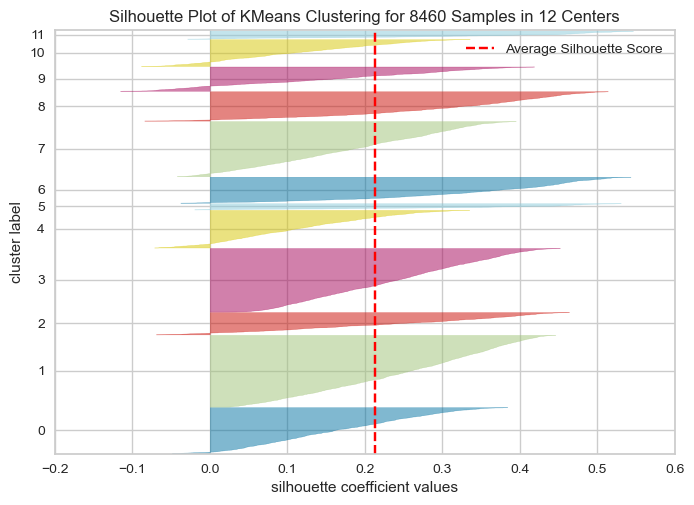

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8460 Samples in 12 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [79]:
# Yellowbrick visualization
model = KMeans(12, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

## Model 1.1: Basic clustering model (12 fixed clusters, 10 features, MinMax scaling)

#### Preparations & specifications

In [80]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness']]

In [81]:
# Check
X.shape

(8460, 10)

In [82]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451
...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>, <Axes: >, <Axes: >]],
      dtype=object)

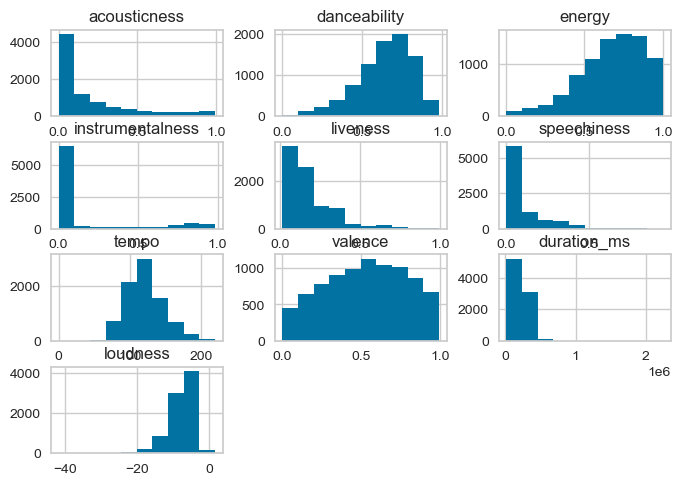

In [83]:
X.hist()

In [84]:
# Scaling model dataset (MinMaxScaler)
scaler = MinMaxScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [85]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [86]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
0,0.064724,0.845761,0.490548,0.004345,0.118038,0.029053,0.547749,0.796165,0.109446,0.737955
1,0.066734,0.756895,0.696134,0.000023,0.123148,0.029158,0.529322,0.781029,0.065677,0.800507
2,0.061307,0.586313,0.912751,0.001604,0.146653,0.140000,0.527586,0.426842,0.087308,0.851981
3,0.359799,0.554648,0.869628,0.000953,0.796627,0.045053,0.459549,0.760848,0.097167,0.812345
4,0.459296,0.538304,0.413328,0.000017,0.106796,0.128421,0.356360,0.519677,0.049975,0.698641


In [87]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000


#### Model building

In [88]:
# Clustering
kmeans = KMeans(n_clusters=12, random_state=42)
kmeans.fit(X_scaled)

D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=12, random_state=42)

In [89]:
# Checking result
labels = kmeans.labels_
print(labels)
print(np.unique(labels))
print(len(labels))

[3 3 0 ... 1 0 4]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
8460


In [90]:
# Predict
clusters = kmeans.predict(X_scaled)

# Check
clusters

array([3, 3, 0, ..., 1, 0, 4])

In [91]:
# Check: Counts per cluster
pd.Series(clusters).value_counts().sort_index()

0      865
1      664
2      513
3     1013
4      498
5      563
6      270
7     1406
8      660
9      345
10     592
11    1071
Name: count, dtype: int64

In [92]:
# Adding clusters to model and original dataframe
X['cluster'] = clusters
df["cluster"] = clusters

C:\Users\user\AppData\Local\Temp\ipykernel_8408\1697861218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


In [93]:
# Adding ID to model df
X['id'] = df['id']

C:\Users\user\AppData\Local\Temp\ipykernel_8408\2796432165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['id'] = df['id']


In [94]:
# Check (should be: 12, 20)
print(X.shape)
print(df.shape)

(8460, 12)
(8460, 20)


In [95]:
# Re-order
X = X[['id', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'cluster']]

In [96]:
X

,id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,3
1,2LawezPeJhN4AWuSB0GtAU,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,3
2,2zYzyRzz6pRmhPzyfMEC8s,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0
3,0GjEhVFGZW8afUYGChu3Rr,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,9
4,1k1Bqnv2R0uJXQN4u6LKYt,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,5
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,5lKpoFNmC76ZZzbdskA1um,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,6
8456,0jv2rlqUHawLg2MRVf6ucQ,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1
8457,4ZUGwm85RzlaD8WLQsC0Ru,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,1
8458,6jINk60m9xyHPVbeVih4nF,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0


In [97]:
df.head(10)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,playlist,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,audio_features,spotify:track:0ofHAoxe9vBkTCp2UQIavz,https://api.spotify.com/v1/tracks/0ofHAoxe9vBk...,https://api.spotify.com/v1/audio-analysis/0ofH...,257800,4,1970s.csv,3
1,2LawezPeJhN4AWuSB0GtAU,0.741,0.697,0,-7.028,1,0.0277,0.0664,0.000023,0.1330,0.774,116.109,audio_features,spotify:track:2LawezPeJhN4AWuSB0GtAU,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,https://api.spotify.com/v1/audio-analysis/2Law...,160133,4,1970s.csv,3
2,2zYzyRzz6pRmhPzyfMEC8s,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400,4,1970s.csv,0
3,0GjEhVFGZW8afUYGChu3Rr,0.543,0.870,9,-6.514,1,0.0428,0.3580,0.000939,0.7920,0.754,100.804,audio_features,spotify:track:0GjEhVFGZW8afUYGChu3Rr,https://api.spotify.com/v1/tracks/0GjEhVFGZW8a...,https://api.spotify.com/v1/audio-analysis/0GjE...,230400,4,1970s.csv,9
4,1k1Bqnv2R0uJXQN4u6LKYt,0.527,0.415,4,-11.451,0,0.1220,0.4570,0.000017,0.1170,0.515,78.169,audio_features,spotify:track:1k1Bqnv2R0uJXQN4u6LKYt,https://api.spotify.com/v1/tracks/1k1Bqnv2R0uJ...,https://api.spotify.com/v1/audio-analysis/1k1B...,125093,4,1970s.csv,5
5,1xsYj84j7hUDDnTTerGWlH,0.392,0.476,1,-7.583,1,0.0249,0.3970,0.000163,0.3090,0.234,78.031,audio_features,spotify:track:1xsYj84j7hUDDnTTerGWlH,https://api.spotify.com/v1/tracks/1xsYj84j7hUD...,https://api.spotify.com/v1/audio-analysis/1xsY...,267597,4,1970s.csv,5
6,07q0QVgO56EorrSGHC48y3,0.768,0.852,4,-6.215,1,0.0380,0.2140,0.000074,0.0723,0.867,128.373,audio_features,spotify:track:07q0QVgO56EorrSGHC48y3,https://api.spotify.com/v1/tracks/07q0QVgO56Eo...,https://api.spotify.com/v1/audio-analysis/07q0...,271240,4,1970s.csv,7
7,3gdewACMIVMEWVbyb8O9sY,0.601,0.532,10,-9.119,1,0.0286,0.4320,0.000006,0.0925,0.341,136.571,audio_features,spotify:track:3gdewACMIVMEWVbyb8O9sY,https://api.spotify.com/v1/tracks/3gdewACMIVME...,https://api.spotify.com/v1/audio-analysis/3gde...,281613,4,1970s.csv,5
8,3EYOJ48Et32uATr9ZmLnAo,0.618,0.748,0,-8.905,1,0.3580,0.0384,0.000004,0.0473,0.663,134.114,audio_features,spotify:track:3EYOJ48Et32uATr9ZmLnAo,https://api.spotify.com/v1/tracks/3EYOJ48Et32u...,https://api.spotify.com/v1/audio-analysis/3EYO...,191947,4,1970s.csv,10
9,5e9TFTbltYBg2xThimr0rU,0.545,0.670,9,-8.810,1,0.0496,0.0090,0.000822,0.0451,0.481,151.553,audio_features,spotify:track:5e9TFTbltYBg2xThimr0rU,https://api.spotify.com/v1/tracks/5e9TFTbltYBg...,https://api.spotify.com/v1/audio-analysis/5e9T...,270213,4,1970s.csv,11


In [98]:
# Save model specifications (pickle)
#def save(model, filename = “filename.pickle”):
with open('1.1-basic/model-basic_scaler.pickle', "wb") as f:
    pickle.dump(scaler, f)

with open('1.1-basic/model-basic_kmeans.pickle', "wb") as f:
    pickle.dump(kmeans, f)

In [99]:
# Saving dataframes
X.to_csv('1.1-basic/X_model-basic.csv', index=False)
df.to_csv('1.1-basic/df_model-basic.csv', index=False)

In [100]:
# (As a function)
#def save(model, filename = “filename.pickle”):
#with open(filename, "wb") as f:
#    pickle.dump(model, f)

#### Evaluation: Face validity - Clusters and predominant playlists

In [101]:
# From how many playlists are the songs in a cluster
df.groupby('cluster')[['playlist']].agg(['count','nunique'])

playlist        
           count nunique
cluster                 
0            865      56
1            664      38
2            513      48
3           1013      60
4            498      44
5            563      57
6            270      23
7           1406      62
8            660      58
9            345      57
10           592      36
11          1071      62

In [102]:
# Predominant playlists per cluster
clusters_playlists = df.groupby(['cluster', 'playlist'])[['id']].count()
clusters_playlists = clusters_playlists.groupby('cluster').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
clusters_playlists.to_csv('1.1-basic/clusters_playlist_investigation.csv', index=True)

# Investigation in place
cluster_of_interest = 7
clusters_playlists.reset_index(inplace=True)
clusters_playlists[clusters_playlists['cluster'] == cluster_of_interest].head(10)

,cluster,playlist,id
326,7,best_of_eurodance.csv,150
327,7,best_of_kpop.csv,139
328,7,handpicked_bravo_hits.csv,112
329,7,handpicked_indie_melody.csv,105
330,7,best_of_rock.csv,59
331,7,best_of_afrobeats.csv,55
332,7,handpicked_berlin.csv,54
333,7,best_of_ska.csv,54
334,7,best_of_electro_swing.csv,52
335,7,2023_tech_house.csv,36


In [103]:
# Predominant clusters per playlist
playlist_clusters = df.groupby(['playlist', 'cluster'])[['id']].count()
playlist_clusters = playlist_clusters.groupby('playlist').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
playlist_clusters.to_csv('1.1-basic/playlist_clusters_investigation.csv', index=True)

# Investigation in place
playlist_of_interest = 'handpicked_faber.csv'
playlist_clusters.reset_index(inplace=True)
playlist_clusters[playlist_clusters['playlist'] == playlist_of_interest].head(10)

,playlist,cluster,id
492,handpicked_faber.csv,2,18
493,handpicked_faber.csv,5,12
494,handpicked_faber.csv,8,4
495,handpicked_faber.csv,0,3
496,handpicked_faber.csv,6,3
497,handpicked_faber.csv,7,3
498,handpicked_faber.csv,3,2
499,handpicked_faber.csv,11,2


In [104]:
# Audio features of the clusters
cluster_features = df.groupby('cluster')[['acousticness', 'danceability', 'energy', 'instrumentalness',
'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature']].mean()
cluster_features = cluster_features.round(2)

# Export
cluster_features.to_csv('1.1-basic/cluster_features.csv', index=True)

# Check
cluster_features

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
cluster,,,,,,,,,,,,
0,0.03,0.45,0.86,0.05,0.20,0.08,135.00,0.37,242865.66,-5.61,0.57,3.97
1,0.06,0.61,0.70,0.79,0.16,0.06,123.08,0.22,313883.11,-9.11,0.50,3.93
2,0.80,0.52,0.31,0.03,0.17,0.07,113.95,0.34,227497.42,-12.56,0.68,3.80
3,0.12,0.78,0.63,0.02,0.13,0.11,113.85,0.77,220649.73,-7.70,0.53,4.00
4,0.08,0.72,0.75,0.72,0.15,0.07,125.09,0.67,273924.76,-8.36,0.56,3.99
5,0.31,0.55,0.52,0.03,0.17,0.07,120.40,0.27,244699.71,-8.81,0.58,3.90
6,0.81,0.33,0.22,0.83,0.13,0.04,107.37,0.17,300429.62,-18.18,0.58,3.73
7,0.07,0.67,0.86,0.02,0.17,0.08,126.48,0.77,218903.69,-5.61,0.57,3.99
8,0.53,0.70,0.63,0.01,0.16,0.13,118.62,0.73,211045.59,-7.68,0.55,3.98


D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


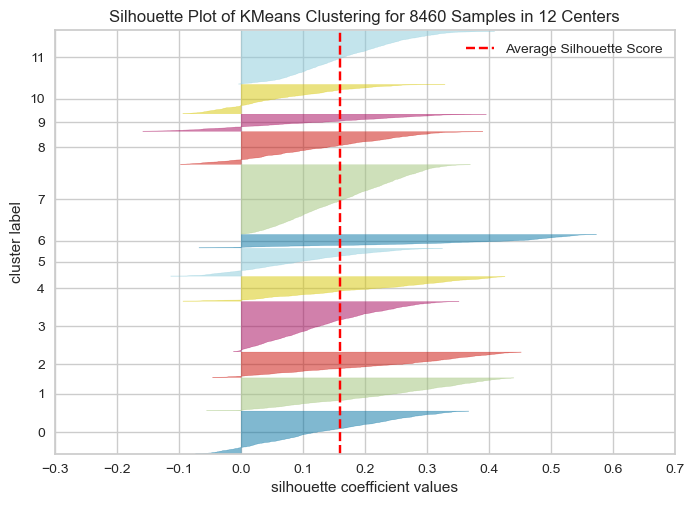

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8460 Samples in 12 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [105]:
# Yellowbrick visualization
model = KMeans(12, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

## Model 2: Basic clustering model (12 fixed clusters, 12 features, Standard scaling)

#### Preparations & specifications

In [106]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness', 'mode', 'time_signature']]

In [107]:
# Check
X.shape

(8460, 12)

In [108]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'time_signature'}>]], dtype=object)

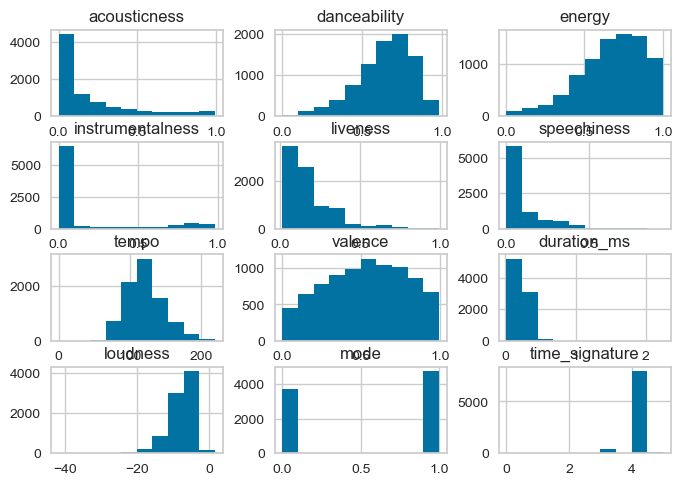

In [109]:
X.hist()

In [110]:
# Scaling model dataset (MinMaxScaler)
scaler = StandardScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [111]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [112]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,-0.541403,1.085934,-0.874484,-0.493573,-0.377564,-0.712767,-0.053361,1.036994,0.254225,-0.498341,0.885895,0.126542
1,-0.533636,0.575176,0.118923,-0.508038,-0.343772,-0.711869,-0.204100,0.977991,-0.885279,0.202359,0.885895,0.126542
2,-0.554606,-0.405244,1.165634,-0.502747,-0.188331,0.234077,-0.218309,-0.402682,-0.322136,0.778965,-1.128802,0.126542
3,0.598731,-0.587238,0.957261,-0.504925,4.109962,-0.576220,-0.774874,0.899320,-0.065457,0.334965,0.885895,0.126542
4,0.983176,-0.681171,-1.247618,-0.508057,-0.451905,0.135260,-1.619007,-0.040796,-1.294099,-0.938729,-1.128802,0.126542


In [113]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000,8460.000000,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367,0.560284,3.962175
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357,0.496382,0.298931
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000,0.000000,0.000000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250,0.000000,4.000000
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000,1.000000,4.000000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000,1.000000,4.000000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000,1.000000,5.000000


#### Model building

In [114]:
# Clustering
kmeans = KMeans(n_clusters=12, random_state=42)
kmeans.fit(X_scaled)

D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=12, random_state=42)

In [115]:
# Checking result
labels = kmeans.labels_
print(labels)
print(np.unique(labels))
print(len(labels))

[ 0  0 10 ...  2  6  2]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
8460


In [116]:
# Predict
clusters = kmeans.predict(X_scaled)

# Check
clusters

array([ 0,  0, 10, ...,  2,  6,  2])

In [117]:
# Check: Counts per cluster
pd.Series(clusters).value_counts().sort_index()

0     1368
1       40
2      894
3      901
4     1252
5      637
6      305
7      405
8      239
9      974
10     767
11     678
Name: count, dtype: int64

In [118]:
# Adding clusters to model and original dataframe
X['cluster'] = clusters
df["cluster"] = clusters

C:\Users\user\AppData\Local\Temp\ipykernel_8408\1697861218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


In [119]:
# Adding ID to model df
X['id'] = df['id']

C:\Users\user\AppData\Local\Temp\ipykernel_8408\2796432165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['id'] = df['id']


In [120]:
# Check (should be: 14, 20)
print(X.shape)
print(df.shape)

(8460, 14)
(8460, 20)


In [121]:
# Re-order
X = X[['id', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature', 'cluster']]

In [122]:
X

,id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4,0
1,2LawezPeJhN4AWuSB0GtAU,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4,0
2,2zYzyRzz6pRmhPzyfMEC8s,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4,10
3,0GjEhVFGZW8afUYGChu3Rr,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4,7
4,1k1Bqnv2R0uJXQN4u6LKYt,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8455,5lKpoFNmC76ZZzbdskA1um,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4,8
8456,0jv2rlqUHawLg2MRVf6ucQ,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4,2
8457,4ZUGwm85RzlaD8WLQsC0Ru,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4,2
8458,6jINk60m9xyHPVbeVih4nF,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3,6


In [123]:
df.head(10)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,playlist,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,audio_features,spotify:track:0ofHAoxe9vBkTCp2UQIavz,https://api.spotify.com/v1/tracks/0ofHAoxe9vBk...,https://api.spotify.com/v1/audio-analysis/0ofH...,257800,4,1970s.csv,0
1,2LawezPeJhN4AWuSB0GtAU,0.741,0.697,0,-7.028,1,0.0277,0.0664,0.000023,0.1330,0.774,116.109,audio_features,spotify:track:2LawezPeJhN4AWuSB0GtAU,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,https://api.spotify.com/v1/audio-analysis/2Law...,160133,4,1970s.csv,0
2,2zYzyRzz6pRmhPzyfMEC8s,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400,4,1970s.csv,10
3,0GjEhVFGZW8afUYGChu3Rr,0.543,0.870,9,-6.514,1,0.0428,0.3580,0.000939,0.7920,0.754,100.804,audio_features,spotify:track:0GjEhVFGZW8afUYGChu3Rr,https://api.spotify.com/v1/tracks/0GjEhVFGZW8a...,https://api.spotify.com/v1/audio-analysis/0GjE...,230400,4,1970s.csv,7
4,1k1Bqnv2R0uJXQN4u6LKYt,0.527,0.415,4,-11.451,0,0.1220,0.4570,0.000017,0.1170,0.515,78.169,audio_features,spotify:track:1k1Bqnv2R0uJXQN4u6LKYt,https://api.spotify.com/v1/tracks/1k1Bqnv2R0uJ...,https://api.spotify.com/v1/audio-analysis/1k1B...,125093,4,1970s.csv,11
5,1xsYj84j7hUDDnTTerGWlH,0.392,0.476,1,-7.583,1,0.0249,0.3970,0.000163,0.3090,0.234,78.031,audio_features,spotify:track:1xsYj84j7hUDDnTTerGWlH,https://api.spotify.com/v1/tracks/1xsYj84j7hUD...,https://api.spotify.com/v1/audio-analysis/1xsY...,267597,4,1970s.csv,9
6,07q0QVgO56EorrSGHC48y3,0.768,0.852,4,-6.215,1,0.0380,0.2140,0.000074,0.0723,0.867,128.373,audio_features,spotify:track:07q0QVgO56EorrSGHC48y3,https://api.spotify.com/v1/tracks/07q0QVgO56Eo...,https://api.spotify.com/v1/audio-analysis/07q0...,271240,4,1970s.csv,0
7,3gdewACMIVMEWVbyb8O9sY,0.601,0.532,10,-9.119,1,0.0286,0.4320,0.000006,0.0925,0.341,136.571,audio_features,spotify:track:3gdewACMIVMEWVbyb8O9sY,https://api.spotify.com/v1/tracks/3gdewACMIVME...,https://api.spotify.com/v1/audio-analysis/3gde...,281613,4,1970s.csv,11
8,3EYOJ48Et32uATr9ZmLnAo,0.618,0.748,0,-8.905,1,0.3580,0.0384,0.000004,0.0473,0.663,134.114,audio_features,spotify:track:3EYOJ48Et32uATr9ZmLnAo,https://api.spotify.com/v1/tracks/3EYOJ48Et32u...,https://api.spotify.com/v1/audio-analysis/3EYO...,191947,4,1970s.csv,3
9,5e9TFTbltYBg2xThimr0rU,0.545,0.670,9,-8.810,1,0.0496,0.0090,0.000822,0.0451,0.481,151.553,audio_features,spotify:track:5e9TFTbltYBg2xThimr0rU,https://api.spotify.com/v1/tracks/5e9TFTbltYBg...,https://api.spotify.com/v1/audio-analysis/5e9T...,270213,4,1970s.csv,5


In [124]:
# Save model specifications (pickle)
#def save(model, filename = “filename.pickle”):
with open('2-basic/model-basic_scaler.pickle', "wb") as f:
    pickle.dump(scaler, f)

with open('2-basic/model-basic_kmeans.pickle', "wb") as f:
    pickle.dump(kmeans, f)

In [125]:
# Saving dataframes
X.to_csv('2-basic/X_model-basic.csv', index=False)
df.to_csv('2-basic/df_model-basic.csv', index=False)

In [126]:
# (As a function)
#def save(model, filename = “filename.pickle”):
#with open(filename, "wb") as f:
#    pickle.dump(model, f)

#### Evaluation: Face validity - Clusters and predominant playlists

In [127]:
# From how many playlists are the songs in a cluster
df.groupby('cluster')[['playlist']].agg(['count','nunique'])

playlist        
           count nunique
cluster                 
0           1368      62
1             40       8
2            894      44
3            901      38
4           1252      62
5            637      58
6            305      55
7            405      60
8            239      25
9            974      63
10           767      62
11           678      57

In [128]:
# Predominant playlists per cluster
clusters_playlists = df.groupby(['cluster', 'playlist'])[['id']].count()
clusters_playlists = clusters_playlists.groupby('cluster').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
clusters_playlists.to_csv('2-basic/clusters_playlist_investigation.csv', index=True)

# Investigation in place
cluster_of_interest = 6
clusters_playlists.reset_index(inplace=True)
clusters_playlists[clusters_playlists['cluster'] == cluster_of_interest].head(10)

,cluster,playlist,id
272,6,handpicked_berlin.csv,28
273,6,best_of_melodic_death_metal.csv,17
274,6,best_of-blues.csv,15
275,6,handpicked_gisbert.csv,14
276,6,best_of_soundtrack1.csv,13
277,6,best_of_grime.csv,13
278,6,2023_best_of.csv,12
279,6,best_of-blues_jazz_soul.csv,12
280,6,best_of_trap.csv,11
281,6,best_of-country.csv,10


In [129]:
# Predominant clusters per playlist
playlist_clusters = df.groupby(['playlist', 'cluster'])[['id']].count()
playlist_clusters = playlist_clusters.groupby('playlist').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
playlist_clusters.to_csv('2-basic/playlist_clusters_investigation.csv', index=True)

# Investigation in place
playlist_of_interest = 'handpicked_faber.csv'
playlist_clusters.reset_index(inplace=True)
playlist_clusters[playlist_clusters['playlist'] == playlist_of_interest].head(10)

,playlist,cluster,id
488,handpicked_faber.csv,11,19
489,handpicked_faber.csv,10,10
490,handpicked_faber.csv,6,6
491,handpicked_faber.csv,8,5
492,handpicked_faber.csv,0,2
493,handpicked_faber.csv,4,2
494,handpicked_faber.csv,5,2
495,handpicked_faber.csv,9,1


In [130]:
# Audio features of the clusters
cluster_features = df.groupby('cluster')[['acousticness', 'danceability', 'energy', 'instrumentalness',
'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature']].mean()
cluster_features = cluster_features.round(2)

# Export
cluster_features.to_csv('2-basic/cluster_features.csv', index=True)

# Check
cluster_features

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
cluster,,,,,,,,,,,,
0,0.14,0.75,0.75,0.05,0.14,0.08,117.47,0.76,215241.57,-6.54,1.00,4.00
1,0.83,0.26,0.15,0.67,0.13,0.05,107.16,0.13,794717.45,-20.25,0.57,3.72
2,0.07,0.67,0.69,0.79,0.14,0.06,122.45,0.37,325616.39,-9.25,0.50,3.99
3,0.23,0.74,0.62,0.01,0.17,0.36,124.50,0.54,192769.32,-7.65,0.50,4.08
4,0.13,0.75,0.75,0.04,0.16,0.09,116.69,0.73,217125.77,-6.31,0.00,4.00
5,0.10,0.47,0.80,0.07,0.18,0.09,168.75,0.54,227879.77,-5.99,0.67,4.00
6,0.40,0.48,0.52,0.16,0.18,0.10,126.13,0.38,227673.73,-9.38,0.64,2.81
7,0.18,0.63,0.75,0.08,0.65,0.12,120.30,0.59,233890.93,-6.79,0.59,3.99
8,0.80,0.32,0.19,0.73,0.13,0.04,104.56,0.16,232823.41,-18.88,0.59,3.83


D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


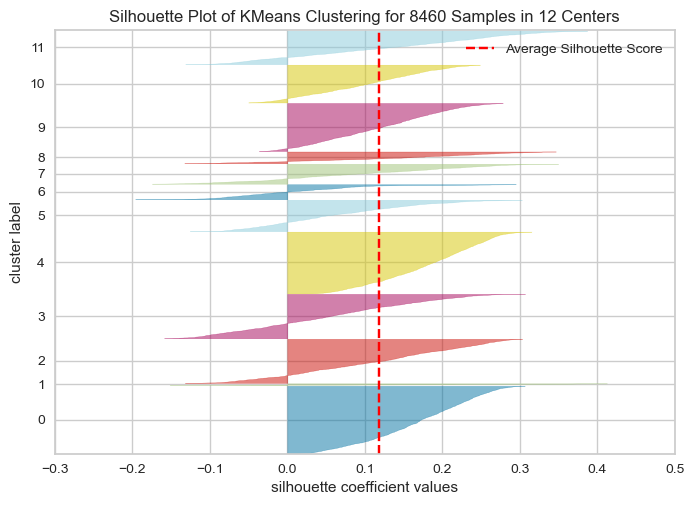

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8460 Samples in 12 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [131]:
# Yellowbrick visualization
model = KMeans(12, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

## Model 2.1: Basic clustering model (12 fixed clusters, 10 features, Standard scaling)

#### Preparations & specifications

In [132]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness']]

In [133]:
# Check
X.shape

(8460, 10)

In [134]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451
...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>, <Axes: >, <Axes: >]],
      dtype=object)

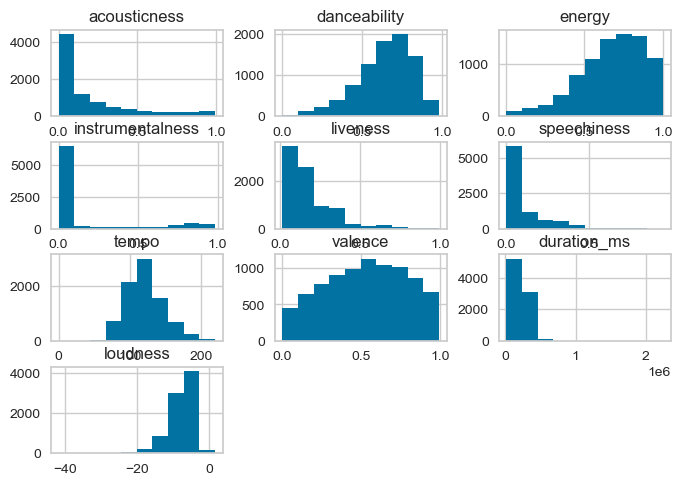

In [135]:
X.hist()

In [136]:
# Scaling model dataset (MinMaxScaler)
scaler = StandardScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [137]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [138]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
0,-0.541403,1.085934,-0.874484,-0.493573,-0.377564,-0.712767,-0.053361,1.036994,0.254225,-0.498341
1,-0.533636,0.575176,0.118923,-0.508038,-0.343772,-0.711869,-0.204100,0.977991,-0.885279,0.202359
2,-0.554606,-0.405244,1.165634,-0.502747,-0.188331,0.234077,-0.218309,-0.402682,-0.322136,0.778965
3,0.598731,-0.587238,0.957261,-0.504925,4.109962,-0.576220,-0.774874,0.899320,-0.065457,0.334965
4,0.983176,-0.681171,-1.247618,-0.508057,-0.451905,0.135260,-1.619007,-0.040796,-1.294099,-0.938729


In [139]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000


#### Model building

In [140]:
# Clustering
kmeans = KMeans(n_clusters=12, random_state=42)
kmeans.fit(X_scaled)

D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=12, random_state=42)

In [141]:
# Checking result
labels = kmeans.labels_
print(labels)
print(np.unique(labels))
print(len(labels))

[8 0 4 ... 5 4 5]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
8460


In [142]:
# Predict
clusters = kmeans.predict(X_scaled)

# Check
clusters

array([8, 0, 4, ..., 5, 4, 5])

In [143]:
# Check: Counts per cluster
pd.Series(clusters).value_counts().sort_index()

0     1679
1      766
2      693
3      590
4     1218
5      514
6      595
7      242
8     1083
9      407
10      29
11     644
Name: count, dtype: int64

In [144]:
# Adding clusters to model and original dataframe
X['cluster'] = clusters
df["cluster"] = clusters

C:\Users\user\AppData\Local\Temp\ipykernel_8408\1697861218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


In [145]:
# Adding ID to model df
X['id'] = df['id']

C:\Users\user\AppData\Local\Temp\ipykernel_8408\2796432165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['id'] = df['id']


In [146]:
# Check (should be: 12, 20)
print(X.shape)
print(df.shape)

(8460, 12)
(8460, 20)


In [147]:
# Re-order
X = X[['id', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'cluster']]

In [148]:
X

,id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,8
1,2LawezPeJhN4AWuSB0GtAU,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,0
2,2zYzyRzz6pRmhPzyfMEC8s,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,4
3,0GjEhVFGZW8afUYGChu3Rr,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,9
4,1k1Bqnv2R0uJXQN4u6LKYt,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,2
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,5lKpoFNmC76ZZzbdskA1um,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,7
8456,0jv2rlqUHawLg2MRVf6ucQ,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,5
8457,4ZUGwm85RzlaD8WLQsC0Ru,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,5
8458,6jINk60m9xyHPVbeVih4nF,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,4


In [149]:
df.head(10)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,playlist,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,audio_features,spotify:track:0ofHAoxe9vBkTCp2UQIavz,https://api.spotify.com/v1/tracks/0ofHAoxe9vBk...,https://api.spotify.com/v1/audio-analysis/0ofH...,257800,4,1970s.csv,8
1,2LawezPeJhN4AWuSB0GtAU,0.741,0.697,0,-7.028,1,0.0277,0.0664,0.000023,0.1330,0.774,116.109,audio_features,spotify:track:2LawezPeJhN4AWuSB0GtAU,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,https://api.spotify.com/v1/audio-analysis/2Law...,160133,4,1970s.csv,0
2,2zYzyRzz6pRmhPzyfMEC8s,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400,4,1970s.csv,4
3,0GjEhVFGZW8afUYGChu3Rr,0.543,0.870,9,-6.514,1,0.0428,0.3580,0.000939,0.7920,0.754,100.804,audio_features,spotify:track:0GjEhVFGZW8afUYGChu3Rr,https://api.spotify.com/v1/tracks/0GjEhVFGZW8a...,https://api.spotify.com/v1/audio-analysis/0GjE...,230400,4,1970s.csv,9
4,1k1Bqnv2R0uJXQN4u6LKYt,0.527,0.415,4,-11.451,0,0.1220,0.4570,0.000017,0.1170,0.515,78.169,audio_features,spotify:track:1k1Bqnv2R0uJXQN4u6LKYt,https://api.spotify.com/v1/tracks/1k1Bqnv2R0uJ...,https://api.spotify.com/v1/audio-analysis/1k1B...,125093,4,1970s.csv,2
5,1xsYj84j7hUDDnTTerGWlH,0.392,0.476,1,-7.583,1,0.0249,0.3970,0.000163,0.3090,0.234,78.031,audio_features,spotify:track:1xsYj84j7hUDDnTTerGWlH,https://api.spotify.com/v1/tracks/1xsYj84j7hUD...,https://api.spotify.com/v1/audio-analysis/1xsY...,267597,4,1970s.csv,4
6,07q0QVgO56EorrSGHC48y3,0.768,0.852,4,-6.215,1,0.0380,0.2140,0.000074,0.0723,0.867,128.373,audio_features,spotify:track:07q0QVgO56EorrSGHC48y3,https://api.spotify.com/v1/tracks/07q0QVgO56Eo...,https://api.spotify.com/v1/audio-analysis/07q0...,271240,4,1970s.csv,0
7,3gdewACMIVMEWVbyb8O9sY,0.601,0.532,10,-9.119,1,0.0286,0.4320,0.000006,0.0925,0.341,136.571,audio_features,spotify:track:3gdewACMIVMEWVbyb8O9sY,https://api.spotify.com/v1/tracks/3gdewACMIVME...,https://api.spotify.com/v1/audio-analysis/3gde...,281613,4,1970s.csv,2
8,3EYOJ48Et32uATr9ZmLnAo,0.618,0.748,0,-8.905,1,0.3580,0.0384,0.000004,0.0473,0.663,134.114,audio_features,spotify:track:3EYOJ48Et32uATr9ZmLnAo,https://api.spotify.com/v1/tracks/3EYOJ48Et32u...,https://api.spotify.com/v1/audio-analysis/3EYO...,191947,4,1970s.csv,11
9,5e9TFTbltYBg2xThimr0rU,0.545,0.670,9,-8.810,1,0.0496,0.0090,0.000822,0.0451,0.481,151.553,audio_features,spotify:track:5e9TFTbltYBg2xThimr0rU,https://api.spotify.com/v1/tracks/5e9TFTbltYBg...,https://api.spotify.com/v1/audio-analysis/5e9T...,270213,4,1970s.csv,1


In [150]:
# Save model specifications (pickle)
#def save(model, filename = “filename.pickle”):
with open('2.1-basic/model-basic_scaler.pickle', "wb") as f:
    pickle.dump(scaler, f)

with open('2.1-basic/model-basic_kmeans.pickle', "wb") as f:
    pickle.dump(kmeans, f)

In [151]:
# Saving dataframes
X.to_csv('2.1-basic/X_model-basic.csv', index=False)
df.to_csv('2.1-basic/df_model-basic.csv', index=False)

In [152]:
# (As a function)
#def save(model, filename = “filename.pickle”):
#with open(filename, "wb") as f:
#    pickle.dump(model, f)

#### Evaluation: Face validity - Clusters and predominant playlists

In [153]:
# From how many playlists are the songs in a cluster
df.groupby('cluster')[['playlist']].agg(['count','nunique'])

playlist        
           count nunique
cluster                 
0           1679      63
1            766      58
2            693      50
3            590      40
4           1218      63
5            514      34
6            595      40
7            242      22
8           1083      64
9            407      61
10            29       6
11           644      40

In [154]:
# Predominant playlists per cluster
clusters_playlists = df.groupby(['cluster', 'playlist'])[['id']].count()
clusters_playlists = clusters_playlists.groupby('cluster').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
clusters_playlists.to_csv('2.1-basic/clusters_playlist_investigation.csv', index=True)

# Investigation in place
cluster_of_interest = 7
clusters_playlists.reset_index(inplace=True)
clusters_playlists[clusters_playlists['cluster'] == cluster_of_interest].head(10)

,cluster,playlist,id
348,7,best_of_soundtrack1.csv,72
349,7,best_of-classic.csv,56
350,7,best_of_soundtrack2.csv,34
351,7,handpicked_worakls.csv,11
352,7,best_of_new_age.csv,11
353,7,handpicked_berlin.csv,9
354,7,handpicked_slowdown_tuesday.csv,7
355,7,best_of_folk.csv,6
356,7,handpicked_gisbert.csv,6
357,7,handpicked_faber.csv,5


In [155]:
# Predominant clusters per playlist
playlist_clusters = df.groupby(['playlist', 'cluster'])[['id']].count()
playlist_clusters = playlist_clusters.groupby('playlist').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
playlist_clusters.to_csv('2.1-basic/playlist_clusters_investigation.csv', index=True)

# Investigation in place
playlist_of_interest = 'handpicked_faber.csv'
playlist_clusters.reset_index(inplace=True)
playlist_clusters[playlist_clusters['playlist'] == playlist_of_interest].head(10)

,playlist,cluster,id
444,handpicked_faber.csv,2,22
445,handpicked_faber.csv,4,8
446,handpicked_faber.csv,1,5
447,handpicked_faber.csv,7,5
448,handpicked_faber.csv,8,5
449,handpicked_faber.csv,0,2


In [156]:
# Audio features of the clusters
cluster_features = df.groupby('cluster')[['acousticness', 'danceability', 'energy', 'instrumentalness',
'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature']].mean()
cluster_features = cluster_features.round(2)

# Export
cluster_features.to_csv('2.1-basic/cluster_features.csv', index=True)

# Check
cluster_features

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
cluster,,,,,,,,,,,,
0,0.10,0.73,0.82,0.03,0.16,0.07,118.84,0.77,215396.42,-5.45,0.54,3.99
1,0.10,0.47,0.79,0.04,0.18,0.08,164.51,0.51,231772.43,-6.04,0.61,3.94
2,0.70,0.55,0.36,0.05,0.16,0.06,116.41,0.37,228083.96,-11.75,0.66,3.84
3,0.21,0.71,0.67,0.01,0.17,0.31,92.55,0.56,207992.19,-6.78,0.48,3.98
4,0.08,0.56,0.75,0.03,0.19,0.06,110.02,0.35,241730.20,-6.18,0.56,3.98
5,0.09,0.71,0.60,0.74,0.13,0.06,119.54,0.35,398644.27,-10.52,0.47,3.96
6,0.07,0.61,0.81,0.77,0.17,0.06,126.88,0.43,233379.91,-7.58,0.57,3.95
7,0.79,0.29,0.19,0.76,0.13,0.04,103.31,0.14,236685.04,-19.25,0.59,3.67
8,0.22,0.75,0.56,0.03,0.13,0.07,115.56,0.63,218449.71,-9.05,0.57,3.98


D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


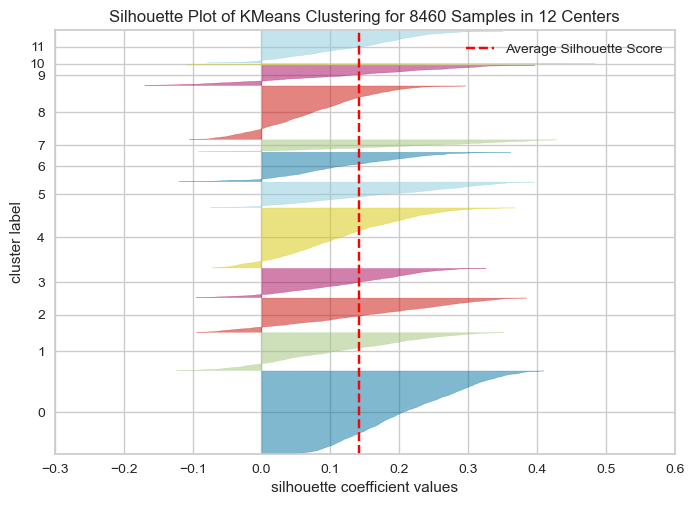

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8460 Samples in 12 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [157]:
# Yellowbrick visualization
model = KMeans(12, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

## Model 3: K25 clustering model (25 fixed clusters, 12 features, MinMax scaling)

#### Preparations & specifications

In [158]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness', 'mode', 'time_signature']]

In [159]:
# Check
X.shape

(8460, 12)

In [160]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'time_signature'}>]], dtype=object)

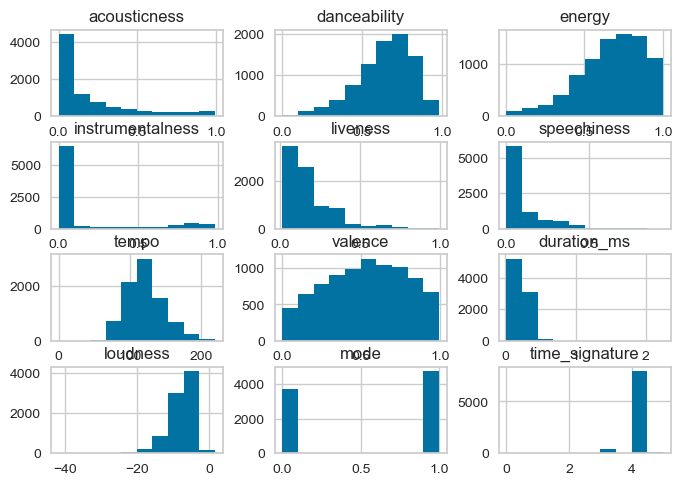

In [161]:
X.hist()

In [162]:
# Scaling model dataset (MinMaxScaler)
scaler = MinMaxScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [163]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [164]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.064724,0.845761,0.490548,0.004345,0.118038,0.029053,0.547749,0.796165,0.109446,0.737955,1.0,0.8
1,0.066734,0.756895,0.696134,0.000023,0.123148,0.029158,0.529322,0.781029,0.065677,0.800507,1.0,0.8
2,0.061307,0.586313,0.912751,0.001604,0.146653,0.140000,0.527586,0.426842,0.087308,0.851981,0.0,0.8
3,0.359799,0.554648,0.869628,0.000953,0.796627,0.045053,0.459549,0.760848,0.097167,0.812345,1.0,0.8
4,0.459296,0.538304,0.413328,0.000017,0.106796,0.128421,0.356360,0.519677,0.049975,0.698641,0.0,0.8


In [165]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000,8460.000000,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367,0.560284,3.962175
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357,0.496382,0.298931
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000,0.000000,0.000000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250,0.000000,4.000000
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000,1.000000,4.000000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000,1.000000,4.000000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000,1.000000,5.000000


#### Model building

In [166]:
# Clustering
kmeans = KMeans(n_clusters=25, random_state=42)
kmeans.fit(X_scaled)

D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=25, random_state=42)

In [167]:
# Checking result
labels = kmeans.labels_
print(labels)
print(np.unique(labels))
print(len(labels))

[15 15  1 ...  6  1  4]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
8460


In [168]:
# Predict
clusters = kmeans.predict(X_scaled)

# Check
clusters

array([15, 15,  1, ...,  6,  1,  4])

In [169]:
# Check: Counts per cluster
pd.Series(clusters).value_counts().sort_index()

0     377
1     465
2      71
3     156
4     222
5     396
6     329
7     673
8     369
9     251
10    690
11    191
12    114
13    381
14    225
15    498
16    217
17    425
18    604
19    304
20    113
21    202
22    623
23    142
24    422
Name: count, dtype: int64

In [170]:
# Adding clusters to model and original dataframe
X['cluster'] = clusters
df["cluster"] = clusters

C:\Users\user\AppData\Local\Temp\ipykernel_8408\1697861218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


In [171]:
# Adding ID to model df
X['id'] = df['id']

C:\Users\user\AppData\Local\Temp\ipykernel_8408\2796432165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['id'] = df['id']


In [172]:
# Check (should be: 14, 20)
print(X.shape)
print(df.shape)

(8460, 14)
(8460, 20)


In [173]:
# Re-order
X = X[['id', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature', 'cluster']]

In [174]:
X

,id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4,15
1,2LawezPeJhN4AWuSB0GtAU,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4,15
2,2zYzyRzz6pRmhPzyfMEC8s,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4,1
3,0GjEhVFGZW8afUYGChu3Rr,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4,21
4,1k1Bqnv2R0uJXQN4u6LKYt,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8455,5lKpoFNmC76ZZzbdskA1um,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4,12
8456,0jv2rlqUHawLg2MRVf6ucQ,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4,16
8457,4ZUGwm85RzlaD8WLQsC0Ru,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4,6
8458,6jINk60m9xyHPVbeVih4nF,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3,1


In [175]:
df.head(10)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,playlist,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,audio_features,spotify:track:0ofHAoxe9vBkTCp2UQIavz,https://api.spotify.com/v1/tracks/0ofHAoxe9vBk...,https://api.spotify.com/v1/audio-analysis/0ofH...,257800,4,1970s.csv,15
1,2LawezPeJhN4AWuSB0GtAU,0.741,0.697,0,-7.028,1,0.0277,0.0664,0.000023,0.1330,0.774,116.109,audio_features,spotify:track:2LawezPeJhN4AWuSB0GtAU,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,https://api.spotify.com/v1/audio-analysis/2Law...,160133,4,1970s.csv,15
2,2zYzyRzz6pRmhPzyfMEC8s,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400,4,1970s.csv,1
3,0GjEhVFGZW8afUYGChu3Rr,0.543,0.870,9,-6.514,1,0.0428,0.3580,0.000939,0.7920,0.754,100.804,audio_features,spotify:track:0GjEhVFGZW8afUYGChu3Rr,https://api.spotify.com/v1/tracks/0GjEhVFGZW8a...,https://api.spotify.com/v1/audio-analysis/0GjE...,230400,4,1970s.csv,21
4,1k1Bqnv2R0uJXQN4u6LKYt,0.527,0.415,4,-11.451,0,0.1220,0.4570,0.000017,0.1170,0.515,78.169,audio_features,spotify:track:1k1Bqnv2R0uJXQN4u6LKYt,https://api.spotify.com/v1/tracks/1k1Bqnv2R0uJ...,https://api.spotify.com/v1/audio-analysis/1k1B...,125093,4,1970s.csv,19
5,1xsYj84j7hUDDnTTerGWlH,0.392,0.476,1,-7.583,1,0.0249,0.3970,0.000163,0.3090,0.234,78.031,audio_features,spotify:track:1xsYj84j7hUDDnTTerGWlH,https://api.spotify.com/v1/tracks/1xsYj84j7hUD...,https://api.spotify.com/v1/audio-analysis/1xsY...,267597,4,1970s.csv,24
6,07q0QVgO56EorrSGHC48y3,0.768,0.852,4,-6.215,1,0.0380,0.2140,0.000074,0.0723,0.867,128.373,audio_features,spotify:track:07q0QVgO56EorrSGHC48y3,https://api.spotify.com/v1/tracks/07q0QVgO56Eo...,https://api.spotify.com/v1/audio-analysis/07q0...,271240,4,1970s.csv,10
7,3gdewACMIVMEWVbyb8O9sY,0.601,0.532,10,-9.119,1,0.0286,0.4320,0.000006,0.0925,0.341,136.571,audio_features,spotify:track:3gdewACMIVMEWVbyb8O9sY,https://api.spotify.com/v1/tracks/3gdewACMIVME...,https://api.spotify.com/v1/audio-analysis/3gde...,281613,4,1970s.csv,24
8,3EYOJ48Et32uATr9ZmLnAo,0.618,0.748,0,-8.905,1,0.3580,0.0384,0.000004,0.0473,0.663,134.114,audio_features,spotify:track:3EYOJ48Et32uATr9ZmLnAo,https://api.spotify.com/v1/tracks/3EYOJ48Et32u...,https://api.spotify.com/v1/audio-analysis/3EYO...,191947,4,1970s.csv,22
9,5e9TFTbltYBg2xThimr0rU,0.545,0.670,9,-8.810,1,0.0496,0.0090,0.000822,0.0451,0.481,151.553,audio_features,spotify:track:5e9TFTbltYBg2xThimr0rU,https://api.spotify.com/v1/tracks/5e9TFTbltYBg...,https://api.spotify.com/v1/audio-analysis/5e9T...,270213,4,1970s.csv,22


In [176]:
# Save model specifications (pickle)
#def save(model, filename = “filename.pickle”):
with open('3-K25/model-basic_scaler.pickle', "wb") as f:
    pickle.dump(scaler, f)

with open('3-K25/model-basic_kmeans.pickle', "wb") as f:
    pickle.dump(kmeans, f)

In [177]:
# Saving dataframes
X.to_csv('3-K25/X_model-basic.csv', index=False)
df.to_csv('3-K25/df_model-basic.csv', index=False)

In [178]:
# (As a function)
#def save(model, filename = “filename.pickle”):
#with open(filename, "wb") as f:
#    pickle.dump(model, f)

#### Evaluation: Face validity - Clusters and predominant playlists

In [179]:
# From how many playlists are the songs in a cluster
df.groupby('cluster')[['playlist']].agg(['count','nunique'])

playlist        
           count nunique
cluster                 
0            377      49
1            465      59
2             71      21
3            156      25
4            222      35
5            396      54
6            329      31
7            673      57
8            369      39
9            251      29
10           690      57
11           191      38
12           114      21
13           381      42
14           225      34
15           498      58
16           217      27
17           425      58
18           604      56
19           304      51
20           113      14
21           202      48
22           623      51
23           142      46
24           422      55

In [180]:
# Predominant playlists per cluster
clusters_playlists = df.groupby(['cluster', 'playlist'])[['id']].count()
clusters_playlists = clusters_playlists.groupby('cluster').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
clusters_playlists.to_csv('3-K25/clusters_playlist_investigation.csv', index=True)

# Investigation in place
cluster_of_interest = 7
clusters_playlists.reset_index(inplace=True)
clusters_playlists[clusters_playlists['cluster'] == cluster_of_interest].head(10)

,cluster,playlist,id
274,7,best_of_eurodance.csv,86
275,7,best_of_kpop.csv,58
276,7,handpicked_indie_melody.csv,50
277,7,handpicked_bravo_hits.csv,47
278,7,best_of_electro_swing.csv,35
279,7,best_of_afrobeats.csv,34
280,7,best_of_rnb.csv,29
281,7,best_of_rap.csv,17
282,7,handpicked_berlin.csv,16
283,7,1990s.csv,16


In [181]:
# Predominant clusters per playlist
playlist_clusters = df.groupby(['playlist', 'cluster'])[['id']].count()
playlist_clusters = playlist_clusters.groupby('playlist').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
playlist_clusters.to_csv('3-K25/playlist_clusters_investigation.csv', index=True)

# Investigation in place
playlist_of_interest = 'handpicked_faber.csv'
playlist_clusters.reset_index(inplace=True)
playlist_clusters[playlist_clusters['playlist'] == playlist_of_interest].head(10)

,playlist,cluster,id
870,handpicked_faber.csv,11,19
871,handpicked_faber.csv,17,7
872,handpicked_faber.csv,13,3
873,handpicked_faber.csv,19,3
874,handpicked_faber.csv,20,3
875,handpicked_faber.csv,1,2
876,handpicked_faber.csv,7,2
877,handpicked_faber.csv,18,2
878,handpicked_faber.csv,24,2
879,handpicked_faber.csv,0,1


In [182]:
# Audio features of the clusters
cluster_features = df.groupby('cluster')[['acousticness', 'danceability', 'energy', 'instrumentalness',
'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature']].mean()
cluster_features = cluster_features.round(2)

# Export
cluster_features.to_csv('3-K25/cluster_features.csv', index=True)

# Check
cluster_features

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
cluster,,,,,,,,,,,,
0,0.03,0.41,0.87,0.04,0.20,0.09,141.29,0.39,242473.37,-5.39,1.0,3.94
1,0.04,0.49,0.85,0.04,0.19,0.08,132.04,0.38,244000.25,-5.65,0.0,3.98
2,0.60,0.55,0.51,0.76,0.16,0.05,114.65,0.37,230644.01,-11.63,1.0,3.93
3,0.08,0.67,0.49,0.79,0.13,0.06,117.91,0.26,339394.27,-11.87,1.0,3.94
4,0.08,0.73,0.73,0.72,0.15,0.07,124.63,0.66,289596.53,-8.43,0.0,3.98
5,0.52,0.70,0.63,0.01,0.16,0.13,119.93,0.72,212518.38,-7.95,1.0,3.97
6,0.06,0.61,0.71,0.79,0.16,0.06,124.09,0.21,322556.86,-9.08,0.0,3.92
7,0.08,0.71,0.82,0.02,0.16,0.09,122.61,0.82,222974.57,-5.99,0.0,4.00
8,0.12,0.77,0.57,0.01,0.17,0.26,124.02,0.36,206488.83,-7.76,1.0,4.04


D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


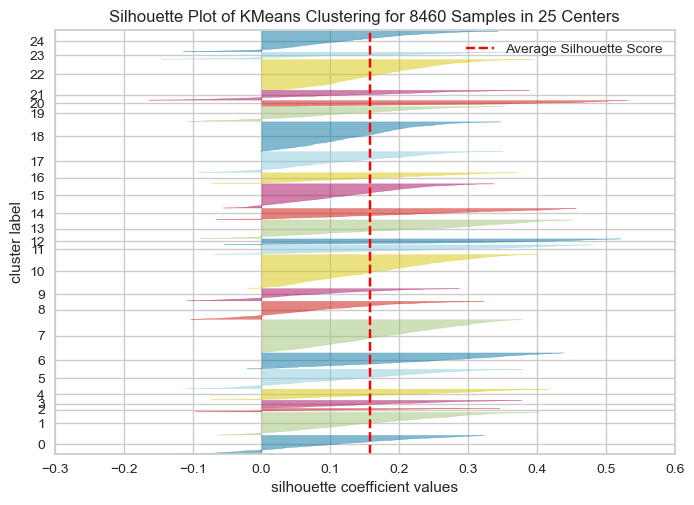

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8460 Samples in 25 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [183]:
# Yellowbrick visualization
model = KMeans(25, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

## Model 3.1: K25 clustering model (25 fixed clusters, 10 features, MinMax scaling)

#### Preparations & specifications

In [184]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness']]

In [185]:
# Check
X.shape

(8460, 10)

In [186]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451
...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>, <Axes: >, <Axes: >]],
      dtype=object)

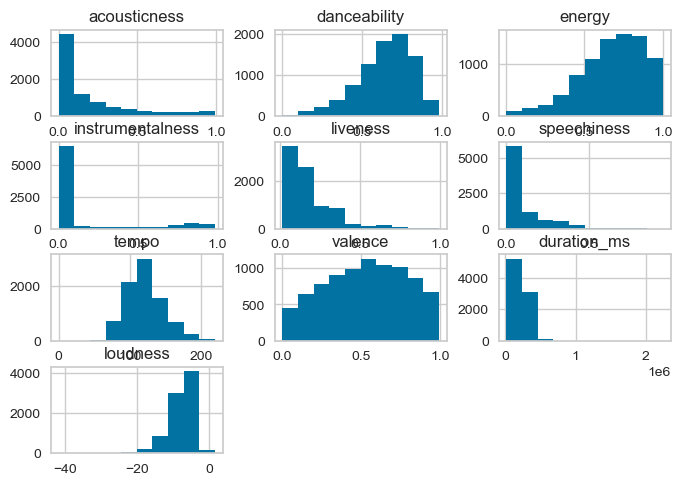

In [187]:
X.hist()

In [188]:
# Scaling model dataset (MinMaxScaler)
scaler = MinMaxScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [189]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [190]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
0,0.064724,0.845761,0.490548,0.004345,0.118038,0.029053,0.547749,0.796165,0.109446,0.737955
1,0.066734,0.756895,0.696134,0.000023,0.123148,0.029158,0.529322,0.781029,0.065677,0.800507
2,0.061307,0.586313,0.912751,0.001604,0.146653,0.140000,0.527586,0.426842,0.087308,0.851981
3,0.359799,0.554648,0.869628,0.000953,0.796627,0.045053,0.459549,0.760848,0.097167,0.812345
4,0.459296,0.538304,0.413328,0.000017,0.106796,0.128421,0.356360,0.519677,0.049975,0.698641


In [191]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000


#### Model building

In [192]:
# Clustering
kmeans = KMeans(n_clusters=25, random_state=42)
kmeans.fit(X_scaled)

D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=25, random_state=42)

In [193]:
# Checking result
labels = kmeans.labels_
print(labels)
print(np.unique(labels))
print(len(labels))

[10 10  7 ... 19 18  5]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
8460


In [194]:
# Predict
clusters = kmeans.predict(X_scaled)

# Check
clusters

array([10, 10,  7, ..., 19, 18,  5])

In [195]:
# Check: Counts per cluster
pd.Series(clusters).value_counts().sort_index()

0     447
1     464
2     757
3     221
4     208
5     344
6     402
7     632
8     337
9     235
10    484
11    115
12    173
13    431
14    456
15    269
16    311
17    346
18    454
19    347
20    297
21     60
22    226
23    296
24    148
Name: count, dtype: int64

In [196]:
# Adding clusters to model and original dataframe
X['cluster'] = clusters
df["cluster"] = clusters

C:\Users\user\AppData\Local\Temp\ipykernel_8408\1697861218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


In [197]:
# Adding ID to model df
X['id'] = df['id']

C:\Users\user\AppData\Local\Temp\ipykernel_8408\2796432165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['id'] = df['id']


In [198]:
# Check (should be: 12, 20)
print(X.shape)
print(df.shape)

(8460, 12)
(8460, 20)


In [199]:
# Re-order
X = X[['id', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'cluster']]

In [200]:
X

,id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,10
1,2LawezPeJhN4AWuSB0GtAU,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,10
2,2zYzyRzz6pRmhPzyfMEC8s,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,7
3,0GjEhVFGZW8afUYGChu3Rr,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,12
4,1k1Bqnv2R0uJXQN4u6LKYt,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,8
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,5lKpoFNmC76ZZzbdskA1um,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,4
8456,0jv2rlqUHawLg2MRVf6ucQ,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,19
8457,4ZUGwm85RzlaD8WLQsC0Ru,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,19
8458,6jINk60m9xyHPVbeVih4nF,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,18


In [201]:
df.head(10)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,playlist,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,audio_features,spotify:track:0ofHAoxe9vBkTCp2UQIavz,https://api.spotify.com/v1/tracks/0ofHAoxe9vBk...,https://api.spotify.com/v1/audio-analysis/0ofH...,257800,4,1970s.csv,10
1,2LawezPeJhN4AWuSB0GtAU,0.741,0.697,0,-7.028,1,0.0277,0.0664,0.000023,0.1330,0.774,116.109,audio_features,spotify:track:2LawezPeJhN4AWuSB0GtAU,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,https://api.spotify.com/v1/audio-analysis/2Law...,160133,4,1970s.csv,10
2,2zYzyRzz6pRmhPzyfMEC8s,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400,4,1970s.csv,7
3,0GjEhVFGZW8afUYGChu3Rr,0.543,0.870,9,-6.514,1,0.0428,0.3580,0.000939,0.7920,0.754,100.804,audio_features,spotify:track:0GjEhVFGZW8afUYGChu3Rr,https://api.spotify.com/v1/tracks/0GjEhVFGZW8a...,https://api.spotify.com/v1/audio-analysis/0GjE...,230400,4,1970s.csv,12
4,1k1Bqnv2R0uJXQN4u6LKYt,0.527,0.415,4,-11.451,0,0.1220,0.4570,0.000017,0.1170,0.515,78.169,audio_features,spotify:track:1k1Bqnv2R0uJXQN4u6LKYt,https://api.spotify.com/v1/tracks/1k1Bqnv2R0uJ...,https://api.spotify.com/v1/audio-analysis/1k1B...,125093,4,1970s.csv,8
5,1xsYj84j7hUDDnTTerGWlH,0.392,0.476,1,-7.583,1,0.0249,0.3970,0.000163,0.3090,0.234,78.031,audio_features,spotify:track:1xsYj84j7hUDDnTTerGWlH,https://api.spotify.com/v1/tracks/1xsYj84j7hUD...,https://api.spotify.com/v1/audio-analysis/1xsY...,267597,4,1970s.csv,8
6,07q0QVgO56EorrSGHC48y3,0.768,0.852,4,-6.215,1,0.0380,0.2140,0.000074,0.0723,0.867,128.373,audio_features,spotify:track:07q0QVgO56EorrSGHC48y3,https://api.spotify.com/v1/tracks/07q0QVgO56Eo...,https://api.spotify.com/v1/audio-analysis/07q0...,271240,4,1970s.csv,2
7,3gdewACMIVMEWVbyb8O9sY,0.601,0.532,10,-9.119,1,0.0286,0.4320,0.000006,0.0925,0.341,136.571,audio_features,spotify:track:3gdewACMIVMEWVbyb8O9sY,https://api.spotify.com/v1/tracks/3gdewACMIVME...,https://api.spotify.com/v1/audio-analysis/3gde...,281613,4,1970s.csv,8
8,3EYOJ48Et32uATr9ZmLnAo,0.618,0.748,0,-8.905,1,0.3580,0.0384,0.000004,0.0473,0.663,134.114,audio_features,spotify:track:3EYOJ48Et32uATr9ZmLnAo,https://api.spotify.com/v1/tracks/3EYOJ48Et32u...,https://api.spotify.com/v1/audio-analysis/3EYO...,191947,4,1970s.csv,6
9,5e9TFTbltYBg2xThimr0rU,0.545,0.670,9,-8.810,1,0.0496,0.0090,0.000822,0.0451,0.481,151.553,audio_features,spotify:track:5e9TFTbltYBg2xThimr0rU,https://api.spotify.com/v1/tracks/5e9TFTbltYBg...,https://api.spotify.com/v1/audio-analysis/5e9T...,270213,4,1970s.csv,7


In [202]:
# Save model specifications (pickle)
#def save(model, filename = “filename.pickle”):
with open('3.1-K25/model-basic_scaler.pickle', "wb") as f:
    pickle.dump(scaler, f)

with open('3.1-K25/model-basic_kmeans.pickle', "wb") as f:
    pickle.dump(kmeans, f)

In [203]:
# Saving dataframes
X.to_csv('3.1-K25/X_model-basic.csv', index=False)
df.to_csv('3.1-K25/df_model-basic.csv', index=False)

In [204]:
# (As a function)
#def save(model, filename = “filename.pickle”):
#with open(filename, "wb") as f:
#    pickle.dump(model, f)

#### Evaluation: Face validity - Clusters and predominant playlists

In [205]:
# From how many playlists are the songs in a cluster
df.groupby('cluster')[['playlist']].agg(['count','nunique'])

playlist        
           count nunique
cluster                 
0            447      44
1            464      60
2            757      52
3            221      32
4            208      18
5            344      25
6            402      34
7            632      54
8            337      48
9            235      37
10           484      58
11           115      28
12           173      48
13           431      55
14           456      56
15           269      37
16           311      27
17           346      51
18           454      55
19           347      32
20           297      32
21            60      18
22           226      30
23           296      45
24           148      42

In [206]:
# Predominant playlists per cluster
clusters_playlists = df.groupby(['cluster', 'playlist'])[['id']].count()
clusters_playlists = clusters_playlists.groupby('cluster').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
clusters_playlists.to_csv('3.1-K25/clusters_playlist_investigation.csv', index=True)

# Investigation in place
cluster_of_interest = 7
clusters_playlists.reset_index(inplace=True)
clusters_playlists[clusters_playlists['cluster'] == cluster_of_interest].head(10)

,cluster,playlist,id
265,7,best_of_kpop.csv,78
266,7,handpicked_indie_melody.csv,62
267,7,handpicked_bravo_hits.csv,50
268,7,best_of_eurodance.csv,47
269,7,best_of_pop.csv,25
270,7,best_of_rock.csv,19
271,7,best_of_electronic.csv,18
272,7,best_of_rap.csv,18
273,7,best_of_trap.csv,18
274,7,2023_best_of.csv,17


In [207]:
# Predominant clusters per playlist
playlist_clusters = df.groupby(['playlist', 'cluster'])[['id']].count()
playlist_clusters = playlist_clusters.groupby('playlist').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
playlist_clusters.to_csv('3.1-K25/playlist_clusters_investigation.csv', index=True)

# Investigation in place
playlist_of_interest = 'handpicked_faber.csv'
playlist_clusters.reset_index(inplace=True)
playlist_clusters[playlist_clusters['playlist'] == playlist_of_interest].head(10)

,playlist,cluster,id
841,handpicked_faber.csv,15,14
842,handpicked_faber.csv,8,12
843,handpicked_faber.csv,23,5
844,handpicked_faber.csv,4,3
845,handpicked_faber.csv,9,2
846,handpicked_faber.csv,14,2
847,handpicked_faber.csv,17,2
848,handpicked_faber.csv,0,1
849,handpicked_faber.csv,1,1
850,handpicked_faber.csv,2,1


In [208]:
# Audio features of the clusters
cluster_features = df.groupby('cluster')[['acousticness', 'danceability', 'energy', 'instrumentalness',
'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature']].mean()
cluster_features = cluster_features.round(2)

# Export
cluster_features.to_csv('3.1-K25/cluster_features.csv', index=True)

# Check
cluster_features

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
cluster,,,,,,,,,,,,
0,0.03,0.42,0.88,0.04,0.18,0.09,133.74,0.30,246654.98,-5.26,0.55,3.97
1,0.12,0.75,0.54,0.02,0.14,0.09,111.69,0.52,227134.81,-8.43,0.53,3.98
2,0.08,0.72,0.85,0.01,0.16,0.07,121.46,0.85,216903.51,-5.48,0.56,3.99
3,0.05,0.72,0.81,0.42,0.17,0.06,124.01,0.67,249319.95,-7.37,0.55,4.00
4,0.84,0.26,0.18,0.85,0.12,0.04,104.36,0.12,312420.91,-19.26,0.58,3.65
5,0.03,0.55,0.86,0.77,0.20,0.06,127.07,0.24,279533.45,-7.01,0.51,3.95
6,0.14,0.77,0.69,0.00,0.16,0.32,116.72,0.70,201024.91,-6.54,0.48,4.04
7,0.06,0.68,0.82,0.01,0.11,0.08,116.50,0.55,222019.33,-5.49,0.55,4.00
8,0.50,0.58,0.50,0.02,0.16,0.06,119.43,0.31,234984.99,-8.90,0.62,3.87


D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


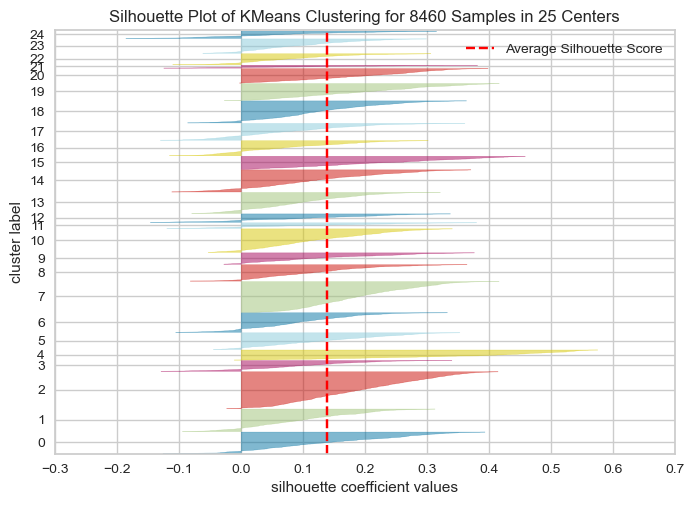

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8460 Samples in 25 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [209]:
# Yellowbrick visualization
model = KMeans(25, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

## Model 4: K25 clustering model (25 fixed clusters, 12 features, Standard scaling)

#### Preparations & specifications

In [210]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness', 'mode', 'time_signature']]

In [211]:
# Check
X.shape

(8460, 12)

In [212]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'time_signature'}>]], dtype=object)

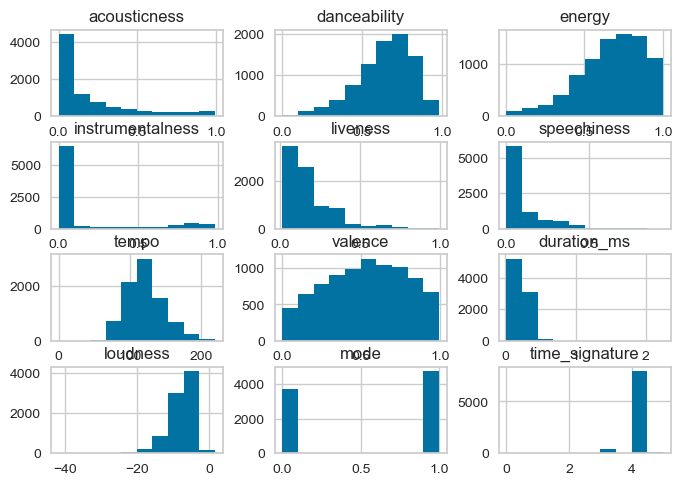

In [213]:
X.hist()

In [214]:
# Scaling model dataset (MinMaxScaler)
scaler = StandardScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [215]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [216]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,-0.541403,1.085934,-0.874484,-0.493573,-0.377564,-0.712767,-0.053361,1.036994,0.254225,-0.498341,0.885895,0.126542
1,-0.533636,0.575176,0.118923,-0.508038,-0.343772,-0.711869,-0.204100,0.977991,-0.885279,0.202359,0.885895,0.126542
2,-0.554606,-0.405244,1.165634,-0.502747,-0.188331,0.234077,-0.218309,-0.402682,-0.322136,0.778965,-1.128802,0.126542
3,0.598731,-0.587238,0.957261,-0.504925,4.109962,-0.576220,-0.774874,0.899320,-0.065457,0.334965,0.885895,0.126542
4,0.983176,-0.681171,-1.247618,-0.508057,-0.451905,0.135260,-1.619007,-0.040796,-1.294099,-0.938729,-1.128802,0.126542


In [217]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000,8460.000000,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367,0.560284,3.962175
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357,0.496382,0.298931
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000,0.000000,0.000000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250,0.000000,4.000000
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000,1.000000,4.000000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000,1.000000,4.000000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000,1.000000,5.000000


#### Model building

In [218]:
# Clustering
kmeans = KMeans(n_clusters=25, random_state=42)
kmeans.fit(X_scaled)

D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=25, random_state=42)

In [219]:
# Checking result
labels = kmeans.labels_
print(labels)
print(np.unique(labels))
print(len(labels))

[ 4 14  1 ... 13 12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
8460


In [220]:
# Predict
clusters = kmeans.predict(X_scaled)

# Check
clusters

array([ 4, 14,  1, ..., 13, 12, 13])

In [221]:
# Check: Counts per cluster
pd.Series(clusters).value_counts().sort_index()

0     487
1     404
2     385
3     182
4     479
5     517
6     801
7      37
8     332
9      29
10    340
11    345
12    149
13    357
14    846
15    411
16    228
17    251
18    112
19    159
20    340
21    540
22    148
23    247
24    334
Name: count, dtype: int64

In [222]:
# Adding clusters to model and original dataframe
X['cluster'] = clusters
df["cluster"] = clusters

C:\Users\user\AppData\Local\Temp\ipykernel_8408\1697861218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


In [223]:
# Adding ID to model df
X['id'] = df['id']

C:\Users\user\AppData\Local\Temp\ipykernel_8408\2796432165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['id'] = df['id']


In [224]:
# Check (should be: 14, 20)
print(X.shape)
print(df.shape)

(8460, 14)
(8460, 20)


In [225]:
# Re-order
X = X[['id', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature', 'cluster']]

In [226]:
X

,id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4,4
1,2LawezPeJhN4AWuSB0GtAU,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4,14
2,2zYzyRzz6pRmhPzyfMEC8s,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4,1
3,0GjEhVFGZW8afUYGChu3Rr,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4,11
4,1k1Bqnv2R0uJXQN4u6LKYt,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8455,5lKpoFNmC76ZZzbdskA1um,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4,19
8456,0jv2rlqUHawLg2MRVf6ucQ,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4,13
8457,4ZUGwm85RzlaD8WLQsC0Ru,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4,13
8458,6jINk60m9xyHPVbeVih4nF,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3,12


In [227]:
df.head(10)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,playlist,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,audio_features,spotify:track:0ofHAoxe9vBkTCp2UQIavz,https://api.spotify.com/v1/tracks/0ofHAoxe9vBk...,https://api.spotify.com/v1/audio-analysis/0ofH...,257800,4,1970s.csv,4
1,2LawezPeJhN4AWuSB0GtAU,0.741,0.697,0,-7.028,1,0.0277,0.0664,0.000023,0.1330,0.774,116.109,audio_features,spotify:track:2LawezPeJhN4AWuSB0GtAU,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,https://api.spotify.com/v1/audio-analysis/2Law...,160133,4,1970s.csv,14
2,2zYzyRzz6pRmhPzyfMEC8s,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400,4,1970s.csv,1
3,0GjEhVFGZW8afUYGChu3Rr,0.543,0.870,9,-6.514,1,0.0428,0.3580,0.000939,0.7920,0.754,100.804,audio_features,spotify:track:0GjEhVFGZW8afUYGChu3Rr,https://api.spotify.com/v1/tracks/0GjEhVFGZW8a...,https://api.spotify.com/v1/audio-analysis/0GjE...,230400,4,1970s.csv,11
4,1k1Bqnv2R0uJXQN4u6LKYt,0.527,0.415,4,-11.451,0,0.1220,0.4570,0.000017,0.1170,0.515,78.169,audio_features,spotify:track:1k1Bqnv2R0uJXQN4u6LKYt,https://api.spotify.com/v1/tracks/1k1Bqnv2R0uJ...,https://api.spotify.com/v1/audio-analysis/1k1B...,125093,4,1970s.csv,16
5,1xsYj84j7hUDDnTTerGWlH,0.392,0.476,1,-7.583,1,0.0249,0.3970,0.000163,0.3090,0.234,78.031,audio_features,spotify:track:1xsYj84j7hUDDnTTerGWlH,https://api.spotify.com/v1/tracks/1xsYj84j7hUD...,https://api.spotify.com/v1/audio-analysis/1xsY...,267597,4,1970s.csv,21
6,07q0QVgO56EorrSGHC48y3,0.768,0.852,4,-6.215,1,0.0380,0.2140,0.000074,0.0723,0.867,128.373,audio_features,spotify:track:07q0QVgO56EorrSGHC48y3,https://api.spotify.com/v1/tracks/07q0QVgO56Eo...,https://api.spotify.com/v1/audio-analysis/07q0...,271240,4,1970s.csv,14
7,3gdewACMIVMEWVbyb8O9sY,0.601,0.532,10,-9.119,1,0.0286,0.4320,0.000006,0.0925,0.341,136.571,audio_features,spotify:track:3gdewACMIVMEWVbyb8O9sY,https://api.spotify.com/v1/tracks/3gdewACMIVME...,https://api.spotify.com/v1/audio-analysis/3gde...,281613,4,1970s.csv,21
8,3EYOJ48Et32uATr9ZmLnAo,0.618,0.748,0,-8.905,1,0.3580,0.0384,0.000004,0.0473,0.663,134.114,audio_features,spotify:track:3EYOJ48Et32uATr9ZmLnAo,https://api.spotify.com/v1/tracks/3EYOJ48Et32u...,https://api.spotify.com/v1/audio-analysis/3EYO...,191947,4,1970s.csv,10
9,5e9TFTbltYBg2xThimr0rU,0.545,0.670,9,-8.810,1,0.0496,0.0090,0.000822,0.0451,0.481,151.553,audio_features,spotify:track:5e9TFTbltYBg2xThimr0rU,https://api.spotify.com/v1/tracks/5e9TFTbltYBg...,https://api.spotify.com/v1/audio-analysis/5e9T...,270213,4,1970s.csv,2


In [228]:
# Save model specifications (pickle)
#def save(model, filename = “filename.pickle”):
with open('4-K25/model-basic_scaler.pickle', "wb") as f:
    pickle.dump(scaler, f)

with open('4-K25/model-basic_kmeans.pickle', "wb") as f:
    pickle.dump(kmeans, f)

In [229]:
# Saving dataframes
X.to_csv('4-K25/X_model-basic.csv', index=False)
df.to_csv('4-K25/df_model-basic.csv', index=False)

In [230]:
# (As a function)
#def save(model, filename = “filename.pickle”):
#with open(filename, "wb") as f:
#    pickle.dump(model, f)

#### Evaluation: Face validity - Clusters and predominant playlists

In [231]:
# From how many playlists are the songs in a cluster
df.groupby('cluster')[['playlist']].agg(['count','nunique'])

playlist        
           count nunique
cluster                 
0            487      44
1            404      53
2            385      50
3            182      27
4            479      57
5            517      56
6            801      57
7             37       8
8            332      39
9             29      19
10           340      38
11           345      59
12           149      38
13           357      31
14           846      57
15           411      37
16           228      52
17           251      33
18           112      25
19           159      17
20           340      55
21           540      59
22           148      37
23           247      33
24           334      35

In [232]:
# Predominant playlists per cluster
clusters_playlists = df.groupby(['cluster', 'playlist'])[['id']].count()
clusters_playlists = clusters_playlists.groupby('cluster').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
clusters_playlists.to_csv('4-K25/clusters_playlist_investigation.csv', index=True)

# Investigation in place
cluster_of_interest = 6
clusters_playlists.reset_index(inplace=True)
clusters_playlists[clusters_playlists['cluster'] == cluster_of_interest].head(10)

,cluster,playlist,id
287,6,best_of_eurodance.csv,87
288,6,best_of_kpop.csv,83
289,6,handpicked_bravo_hits.csv,58
290,6,handpicked_indie_melody.csv,53
291,6,best_of_afrobeats.csv,52
292,6,best_of_electro_swing.csv,50
293,6,best_of_rnb.csv,37
294,6,2023_best_of.csv,23
295,6,best_of_reggaeton.csv,21
296,6,best_of_electronic.csv,19


In [233]:
# Predominant clusters per playlist
playlist_clusters = df.groupby(['playlist', 'cluster'])[['id']].count()
playlist_clusters = playlist_clusters.groupby('playlist').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
playlist_clusters.to_csv('4-K25/playlist_clusters_investigation.csv', index=True)

# Investigation in place
playlist_of_interest = 'handpicked_faber.csv'
playlist_clusters.reset_index(inplace=True)
playlist_clusters[playlist_clusters['playlist'] == playlist_of_interest].head(10)

,playlist,cluster,id
829,handpicked_faber.csv,16,13
830,handpicked_faber.csv,8,10
831,handpicked_faber.csv,20,4
832,handpicked_faber.csv,22,4
833,handpicked_faber.csv,1,3
834,handpicked_faber.csv,19,3
835,handpicked_faber.csv,2,2
836,handpicked_faber.csv,5,2
837,handpicked_faber.csv,12,2
838,handpicked_faber.csv,4,1


In [234]:
# Audio features of the clusters
cluster_features = df.groupby('cluster')[['acousticness', 'danceability', 'energy', 'instrumentalness',
'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature']].mean()
cluster_features = cluster_features.round(2)

# Export
cluster_features.to_csv('4-K25/cluster_features.csv', index=True)

# Check
cluster_features

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
cluster,,,,,,,,,,,,
0,0.05,0.53,0.86,0.04,0.23,0.06,113.65,0.47,238247.02,-5.36,1.00,4.00
1,0.08,0.53,0.77,0.04,0.19,0.06,106.67,0.36,253618.99,-6.20,0.00,4.00
2,0.11,0.48,0.80,0.03,0.17,0.08,168.01,0.55,221825.63,-5.97,1.00,4.00
3,0.34,0.65,0.44,0.80,0.14,0.06,113.79,0.39,259271.82,-13.65,0.58,4.02
4,0.30,0.72,0.57,0.03,0.14,0.06,112.27,0.74,223869.76,-9.90,1.00,4.00
5,0.16,0.78,0.59,0.02,0.14,0.09,115.88,0.52,209294.78,-7.83,0.00,4.00
6,0.11,0.74,0.81,0.03,0.17,0.07,116.97,0.78,218647.68,-5.69,0.00,4.00
7,0.82,0.26,0.16,0.67,0.13,0.05,107.63,0.13,816705.46,-19.98,0.57,3.76
8,0.78,0.52,0.30,0.04,0.16,0.06,110.81,0.33,222133.19,-12.82,0.90,4.03


D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


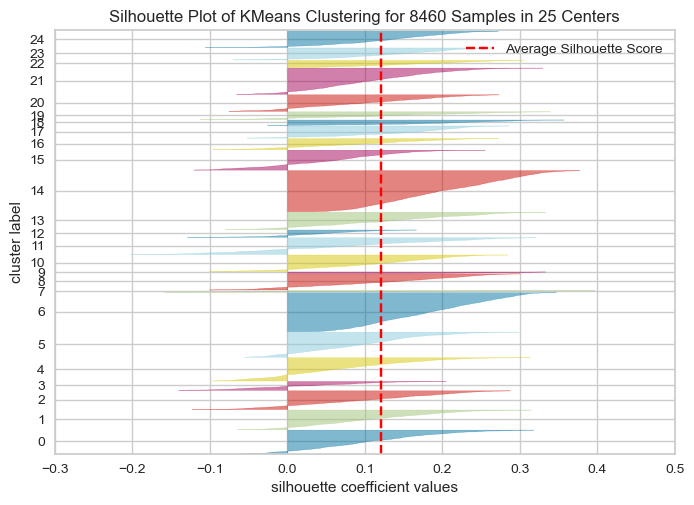

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8460 Samples in 25 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [235]:
# Yellowbrick visualization
model = KMeans(25, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

## Model 4.1: K25 clustering model (25 fixed clusters, 10 features, Standard scaling)

#### Preparations & specifications

In [236]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness']]

In [237]:
# Check
X.shape

(8460, 10)

In [238]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451
...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>, <Axes: >, <Axes: >]],
      dtype=object)

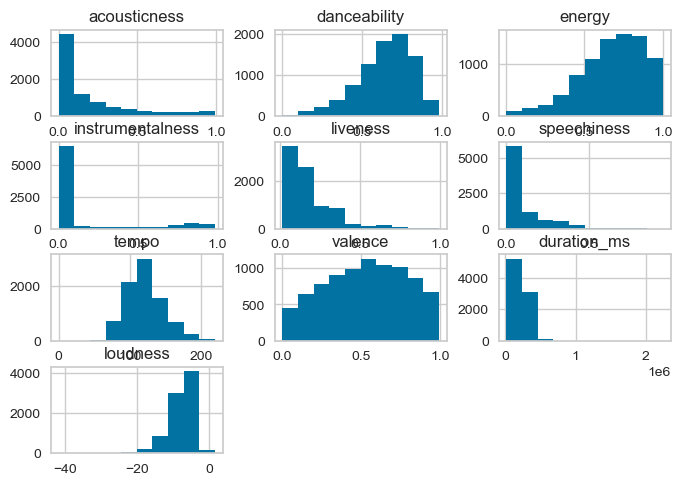

In [239]:
X.hist()

In [240]:
# Scaling model dataset (MinMaxScaler)
scaler = StandardScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [241]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [242]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
0,-0.541403,1.085934,-0.874484,-0.493573,-0.377564,-0.712767,-0.053361,1.036994,0.254225,-0.498341
1,-0.533636,0.575176,0.118923,-0.508038,-0.343772,-0.711869,-0.204100,0.977991,-0.885279,0.202359
2,-0.554606,-0.405244,1.165634,-0.502747,-0.188331,0.234077,-0.218309,-0.402682,-0.322136,0.778965
3,0.598731,-0.587238,0.957261,-0.504925,4.109962,-0.576220,-0.774874,0.899320,-0.065457,0.334965
4,0.983176,-0.681171,-1.247618,-0.508057,-0.451905,0.135260,-1.619007,-0.040796,-1.294099,-0.938729


In [243]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000


#### Model building

In [244]:
# Clustering
kmeans = KMeans(n_clusters=25, random_state=42)
kmeans.fit(X_scaled)

D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=25, random_state=42)

In [245]:
# Checking result
labels = kmeans.labels_
print(labels)
print(np.unique(labels))
print(len(labels))

[ 1  9  4 ...  7 24  7]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
8460


In [246]:
# Predict
clusters = kmeans.predict(X_scaled)

# Check
clusters

array([ 1,  9,  4, ...,  7, 24,  7])

In [247]:
# Check: Counts per cluster
pd.Series(clusters).value_counts().sort_index()

0     174
1     408
2     374
3     329
4     520
5     296
6     458
7     416
8     236
9     776
10    250
11    291
12     28
13    316
14    322
15    337
16    252
17    146
18     95
19    552
20    118
21    299
22    545
23    351
24    571
Name: count, dtype: int64

In [248]:
# Adding clusters to model and original dataframe
X['cluster'] = clusters
df["cluster"] = clusters

C:\Users\user\AppData\Local\Temp\ipykernel_8408\1697861218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


In [249]:
# Adding ID to model df
X['id'] = df['id']

C:\Users\user\AppData\Local\Temp\ipykernel_8408\2796432165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['id'] = df['id']


In [250]:
# Check (should be: 12, 20)
print(X.shape)
print(df.shape)

(8460, 12)
(8460, 20)


In [251]:
# Re-order
X = X[['id', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'cluster']]

In [252]:
X

,id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1
1,2LawezPeJhN4AWuSB0GtAU,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,9
2,2zYzyRzz6pRmhPzyfMEC8s,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,4
3,0GjEhVFGZW8afUYGChu3Rr,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,10
4,1k1Bqnv2R0uJXQN4u6LKYt,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,15
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,5lKpoFNmC76ZZzbdskA1um,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0
8456,0jv2rlqUHawLg2MRVf6ucQ,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,7
8457,4ZUGwm85RzlaD8WLQsC0Ru,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,7
8458,6jINk60m9xyHPVbeVih4nF,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,24


In [253]:
df.head(10)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,playlist,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,audio_features,spotify:track:0ofHAoxe9vBkTCp2UQIavz,https://api.spotify.com/v1/tracks/0ofHAoxe9vBk...,https://api.spotify.com/v1/audio-analysis/0ofH...,257800,4,1970s.csv,1
1,2LawezPeJhN4AWuSB0GtAU,0.741,0.697,0,-7.028,1,0.0277,0.0664,0.000023,0.1330,0.774,116.109,audio_features,spotify:track:2LawezPeJhN4AWuSB0GtAU,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,https://api.spotify.com/v1/audio-analysis/2Law...,160133,4,1970s.csv,9
2,2zYzyRzz6pRmhPzyfMEC8s,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400,4,1970s.csv,4
3,0GjEhVFGZW8afUYGChu3Rr,0.543,0.870,9,-6.514,1,0.0428,0.3580,0.000939,0.7920,0.754,100.804,audio_features,spotify:track:0GjEhVFGZW8afUYGChu3Rr,https://api.spotify.com/v1/tracks/0GjEhVFGZW8a...,https://api.spotify.com/v1/audio-analysis/0GjE...,230400,4,1970s.csv,10
4,1k1Bqnv2R0uJXQN4u6LKYt,0.527,0.415,4,-11.451,0,0.1220,0.4570,0.000017,0.1170,0.515,78.169,audio_features,spotify:track:1k1Bqnv2R0uJXQN4u6LKYt,https://api.spotify.com/v1/tracks/1k1Bqnv2R0uJ...,https://api.spotify.com/v1/audio-analysis/1k1B...,125093,4,1970s.csv,15
5,1xsYj84j7hUDDnTTerGWlH,0.392,0.476,1,-7.583,1,0.0249,0.3970,0.000163,0.3090,0.234,78.031,audio_features,spotify:track:1xsYj84j7hUDDnTTerGWlH,https://api.spotify.com/v1/tracks/1xsYj84j7hUD...,https://api.spotify.com/v1/audio-analysis/1xsY...,267597,4,1970s.csv,15
6,07q0QVgO56EorrSGHC48y3,0.768,0.852,4,-6.215,1,0.0380,0.2140,0.000074,0.0723,0.867,128.373,audio_features,spotify:track:07q0QVgO56EorrSGHC48y3,https://api.spotify.com/v1/tracks/07q0QVgO56Eo...,https://api.spotify.com/v1/audio-analysis/07q0...,271240,4,1970s.csv,9
7,3gdewACMIVMEWVbyb8O9sY,0.601,0.532,10,-9.119,1,0.0286,0.4320,0.000006,0.0925,0.341,136.571,audio_features,spotify:track:3gdewACMIVMEWVbyb8O9sY,https://api.spotify.com/v1/tracks/3gdewACMIVME...,https://api.spotify.com/v1/audio-analysis/3gde...,281613,4,1970s.csv,8
8,3EYOJ48Et32uATr9ZmLnAo,0.618,0.748,0,-8.905,1,0.3580,0.0384,0.000004,0.0473,0.663,134.114,audio_features,spotify:track:3EYOJ48Et32uATr9ZmLnAo,https://api.spotify.com/v1/tracks/3EYOJ48Et32u...,https://api.spotify.com/v1/audio-analysis/3EYO...,191947,4,1970s.csv,5
9,5e9TFTbltYBg2xThimr0rU,0.545,0.670,9,-8.810,1,0.0496,0.0090,0.000822,0.0451,0.481,151.553,audio_features,spotify:track:5e9TFTbltYBg2xThimr0rU,https://api.spotify.com/v1/tracks/5e9TFTbltYBg...,https://api.spotify.com/v1/audio-analysis/5e9T...,270213,4,1970s.csv,16


In [254]:
# Save model specifications (pickle)
#def save(model, filename = “filename.pickle”):
with open('4.1-K25/model-basic_scaler.pickle', "wb") as f:
    pickle.dump(scaler, f)

with open('4.1-K25/model-basic_kmeans.pickle', "wb") as f:
    pickle.dump(kmeans, f)

In [255]:
# Saving dataframes
X.to_csv('4.1-K25/X_model-basic.csv', index=False)
df.to_csv('4.1-K25/df_model-basic.csv', index=False)

In [256]:
# (As a function)
#def save(model, filename = “filename.pickle”):
#with open(filename, "wb") as f:
#    pickle.dump(model, f)

#### Evaluation: Face validity - Clusters and predominant playlists

In [257]:
# From how many playlists are the songs in a cluster
df.groupby('cluster')[['playlist']].agg(['count','nunique'])

playlist        
           count nunique
cluster                 
0            174      24
1            408      54
2            374      57
3            329      37
4            520      49
5            296      36
6            458      37
7            416      29
8            236      43
9            776      54
10           250      53
11           291      34
12            28       6
13           316      51
14           322      41
15           337      53
16           252      44
17           146      22
18            95      34
19           552      52
20           118      15
21           299      24
22           545      51
23           351      46
24           571      56

In [258]:
# Predominant playlists per cluster
clusters_playlists = df.groupby(['cluster', 'playlist'])[['id']].count()
clusters_playlists = clusters_playlists.groupby('cluster').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
clusters_playlists.to_csv('4.1-K25/clusters_playlist_investigation.csv', index=True)

# Investigation in place
cluster_of_interest = 7
clusters_playlists.reset_index(inplace=True)
clusters_playlists[clusters_playlists['cluster'] == cluster_of_interest].head(10)

,cluster,playlist,id
294,7,best_of_trip_hop.csv,82
295,7,handpicked_afterlife.csv,71
296,7,best_of_organic_house.csv,38
297,7,handpicked_hungry_music.csv,38
298,7,best_of_deep_house.csv,38
299,7,handpicked_indie_melody.csv,35
300,7,handpicked_be_svendsen.csv,26
301,7,handpicked_worakls.csv,20
302,7,best_of_eurodance.csv,11
303,7,handpicked_sonne_mond_sterne.csv,8


In [259]:
# Predominant clusters per playlist
playlist_clusters = df.groupby(['playlist', 'cluster'])[['id']].count()
playlist_clusters = playlist_clusters.groupby('playlist').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
playlist_clusters.to_csv('4.1-K25/playlist_clusters_investigation.csv', index=True)

# Investigation in place
playlist_of_interest = 'handpicked_faber.csv'
playlist_clusters.reset_index(inplace=True)
playlist_clusters[playlist_clusters['playlist'] == playlist_of_interest].head(10)

,playlist,cluster,id
824,handpicked_faber.csv,14,15
825,handpicked_faber.csv,8,9
826,handpicked_faber.csv,15,5
827,handpicked_faber.csv,2,4
828,handpicked_faber.csv,23,3
829,handpicked_faber.csv,4,2
830,handpicked_faber.csv,9,2
831,handpicked_faber.csv,20,2
832,handpicked_faber.csv,0,1
833,handpicked_faber.csv,1,1


In [260]:
# Audio features of the clusters
cluster_features = df.groupby('cluster')[['acousticness', 'danceability', 'energy', 'instrumentalness',
'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature']].mean()
cluster_features = cluster_features.round(2)

# Export
cluster_features.to_csv('4.1-K25/cluster_features.csv', index=True)

# Check
cluster_features

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
cluster,,,,,,,,,,,,
0,0.62,0.43,0.35,0.83,0.13,0.04,114.14,0.23,230559.56,-14.48,0.55,3.86
1,0.11,0.73,0.59,0.05,0.12,0.06,119.89,0.78,244085.80,-11.24,0.62,4.00
2,0.59,0.72,0.56,0.03,0.15,0.07,113.27,0.68,206378.51,-8.33,0.58,3.95
3,0.07,0.73,0.79,0.73,0.14,0.06,126.17,0.65,222207.13,-7.76,0.62,3.99
4,0.05,0.51,0.86,0.03,0.17,0.07,106.83,0.42,230191.15,-5.18,0.58,3.99
5,0.29,0.77,0.68,0.01,0.19,0.33,144.76,0.74,189416.52,-6.94,0.51,4.04
6,0.18,0.70,0.68,0.00,0.17,0.32,92.51,0.57,205710.77,-6.43,0.48,4.00
7,0.07,0.72,0.61,0.78,0.12,0.06,120.46,0.33,407249.76,-10.31,0.44,3.96
8,0.50,0.49,0.44,0.04,0.15,0.05,158.96,0.39,237888.42,-10.30,0.68,3.77


D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


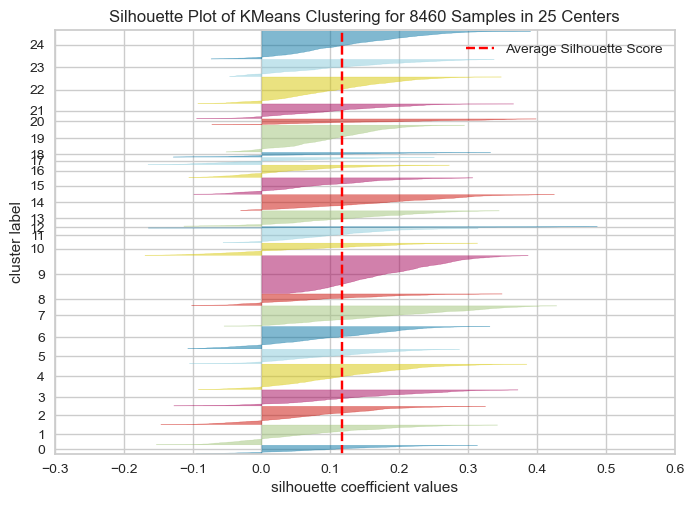

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8460 Samples in 25 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [261]:
# Yellowbrick visualization
model = KMeans(25, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

## Model 5: K24 clustering model (24 fixed clusters, 12 features, MinMax scaling)

#### Preparations & specifications

In [262]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness', 'mode', 'time_signature']]

In [263]:
# Check
X.shape

(8460, 12)

In [264]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'time_signature'}>]], dtype=object)

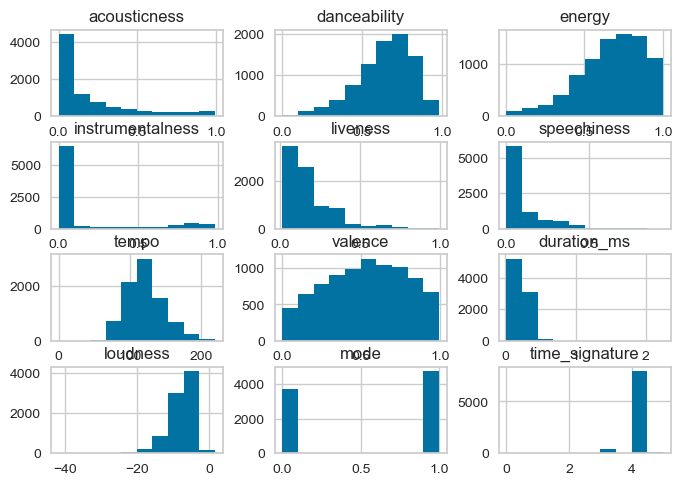

In [265]:
X.hist()

In [266]:
# Scaling model dataset (MinMaxScaler)
scaler = MinMaxScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [267]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [268]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.064724,0.845761,0.490548,0.004345,0.118038,0.029053,0.547749,0.796165,0.109446,0.737955,1.0,0.8
1,0.066734,0.756895,0.696134,0.000023,0.123148,0.029158,0.529322,0.781029,0.065677,0.800507,1.0,0.8
2,0.061307,0.586313,0.912751,0.001604,0.146653,0.140000,0.527586,0.426842,0.087308,0.851981,0.0,0.8
3,0.359799,0.554648,0.869628,0.000953,0.796627,0.045053,0.459549,0.760848,0.097167,0.812345,1.0,0.8
4,0.459296,0.538304,0.413328,0.000017,0.106796,0.128421,0.356360,0.519677,0.049975,0.698641,0.0,0.8


In [269]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000,8460.000000,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367,0.560284,3.962175
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357,0.496382,0.298931
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000,0.000000,0.000000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250,0.000000,4.000000
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000,1.000000,4.000000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000,1.000000,4.000000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000,1.000000,5.000000


#### Model building

In [270]:
# Clustering
kmeans = KMeans(n_clusters=24, random_state=42)
kmeans.fit(X_scaled)

D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=24, random_state=42)

In [271]:
# Checking result
labels = kmeans.labels_
print(labels)
print(np.unique(labels))
print(len(labels))

[ 1  1  0 ... 14 12  4]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
8460


In [272]:
# Predict
clusters = kmeans.predict(X_scaled)

# Check
clusters

array([ 1,  1,  0, ..., 14, 12,  4])

In [273]:
# Check: Counts per cluster
pd.Series(clusters).value_counts().sort_index()

0     569
1     490
2     628
3      93
4     225
5     415
6     190
7     327
8     425
9     466
10    114
11    383
12    314
13    379
14    327
15    398
16    699
17    370
18    108
19    631
20    203
21    247
22    319
23    140
Name: count, dtype: int64

In [274]:
# Adding clusters to model and original dataframe
X['cluster'] = clusters
df["cluster"] = clusters

C:\Users\user\AppData\Local\Temp\ipykernel_8408\1697861218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


In [275]:
# Adding ID to model df
X['id'] = df['id']

C:\Users\user\AppData\Local\Temp\ipykernel_8408\2796432165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['id'] = df['id']


In [276]:
# Check (should be: 14, 20)
print(X.shape)
print(df.shape)

(8460, 14)
(8460, 20)


In [277]:
# Re-order
X = X[['id', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature', 'cluster']]

In [278]:
X

,id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4,1
1,2LawezPeJhN4AWuSB0GtAU,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4,1
2,2zYzyRzz6pRmhPzyfMEC8s,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4,0
3,0GjEhVFGZW8afUYGChu3Rr,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4,20
4,1k1Bqnv2R0uJXQN4u6LKYt,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8455,5lKpoFNmC76ZZzbdskA1um,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4,10
8456,0jv2rlqUHawLg2MRVf6ucQ,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4,7
8457,4ZUGwm85RzlaD8WLQsC0Ru,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4,14
8458,6jINk60m9xyHPVbeVih4nF,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3,12


In [279]:
df.head(10)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,playlist,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,audio_features,spotify:track:0ofHAoxe9vBkTCp2UQIavz,https://api.spotify.com/v1/tracks/0ofHAoxe9vBk...,https://api.spotify.com/v1/audio-analysis/0ofH...,257800,4,1970s.csv,1
1,2LawezPeJhN4AWuSB0GtAU,0.741,0.697,0,-7.028,1,0.0277,0.0664,0.000023,0.1330,0.774,116.109,audio_features,spotify:track:2LawezPeJhN4AWuSB0GtAU,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,https://api.spotify.com/v1/audio-analysis/2Law...,160133,4,1970s.csv,1
2,2zYzyRzz6pRmhPzyfMEC8s,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400,4,1970s.csv,0
3,0GjEhVFGZW8afUYGChu3Rr,0.543,0.870,9,-6.514,1,0.0428,0.3580,0.000939,0.7920,0.754,100.804,audio_features,spotify:track:0GjEhVFGZW8afUYGChu3Rr,https://api.spotify.com/v1/tracks/0GjEhVFGZW8a...,https://api.spotify.com/v1/audio-analysis/0GjE...,230400,4,1970s.csv,20
4,1k1Bqnv2R0uJXQN4u6LKYt,0.527,0.415,4,-11.451,0,0.1220,0.4570,0.000017,0.1170,0.515,78.169,audio_features,spotify:track:1k1Bqnv2R0uJXQN4u6LKYt,https://api.spotify.com/v1/tracks/1k1Bqnv2R0uJ...,https://api.spotify.com/v1/audio-analysis/1k1B...,125093,4,1970s.csv,22
5,1xsYj84j7hUDDnTTerGWlH,0.392,0.476,1,-7.583,1,0.0249,0.3970,0.000163,0.3090,0.234,78.031,audio_features,spotify:track:1xsYj84j7hUDDnTTerGWlH,https://api.spotify.com/v1/tracks/1xsYj84j7hUD...,https://api.spotify.com/v1/audio-analysis/1xsY...,267597,4,1970s.csv,5
6,07q0QVgO56EorrSGHC48y3,0.768,0.852,4,-6.215,1,0.0380,0.2140,0.000074,0.0723,0.867,128.373,audio_features,spotify:track:07q0QVgO56EorrSGHC48y3,https://api.spotify.com/v1/tracks/07q0QVgO56Eo...,https://api.spotify.com/v1/audio-analysis/07q0...,271240,4,1970s.csv,16
7,3gdewACMIVMEWVbyb8O9sY,0.601,0.532,10,-9.119,1,0.0286,0.4320,0.000006,0.0925,0.341,136.571,audio_features,spotify:track:3gdewACMIVMEWVbyb8O9sY,https://api.spotify.com/v1/tracks/3gdewACMIVME...,https://api.spotify.com/v1/audio-analysis/3gde...,281613,4,1970s.csv,5
8,3EYOJ48Et32uATr9ZmLnAo,0.618,0.748,0,-8.905,1,0.3580,0.0384,0.000004,0.0473,0.663,134.114,audio_features,spotify:track:3EYOJ48Et32uATr9ZmLnAo,https://api.spotify.com/v1/tracks/3EYOJ48Et32u...,https://api.spotify.com/v1/audio-analysis/3EYO...,191947,4,1970s.csv,2
9,5e9TFTbltYBg2xThimr0rU,0.545,0.670,9,-8.810,1,0.0496,0.0090,0.000822,0.0451,0.481,151.553,audio_features,spotify:track:5e9TFTbltYBg2xThimr0rU,https://api.spotify.com/v1/tracks/5e9TFTbltYBg...,https://api.spotify.com/v1/audio-analysis/5e9T...,270213,4,1970s.csv,2


In [280]:
# Save model specifications (pickle)
#def save(model, filename = “filename.pickle”):
with open('5-K24/model_scaler.pickle', "wb") as f:
    pickle.dump(scaler, f)

with open('5-K24/model_kmeans.pickle', "wb") as f:
    pickle.dump(kmeans, f)

In [281]:
# Saving dataframes
X.to_csv('5-K24/X_model.csv', index=False)
df.to_csv('5-K24/df_model.csv', index=False)

In [282]:
# (As a function)
#def save(model, filename = “filename.pickle”):
#with open(filename, "wb") as f:
#    pickle.dump(model, f)

#### Evaluation: Face validity - Clusters and predominant playlists

In [283]:
# From how many playlists are the songs in a cluster
df.groupby('cluster')[['playlist']].agg(['count','nunique'])

playlist        
           count nunique
cluster                 
0            569      55
1            490      58
2            628      51
3             93      23
4            225      35
5            415      53
6            190      39
7            327      32
8            425      45
9            466      59
10           114      21
11           383      49
12           314      49
13           379      41
14           327      31
15           398      54
16           699      57
17           370      39
18           108      12
19           631      57
20           203      48
21           247      35
22           319      50
23           140      45

In [284]:
# Predominant playlists per cluster
clusters_playlists = df.groupby(['cluster', 'playlist'])[['id']].count()
clusters_playlists = clusters_playlists.groupby('cluster').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
clusters_playlists.to_csv('5-K24/clusters_playlist_investigation.csv', index=True)

# Investigation in place
cluster_of_interest = 7
clusters_playlists.reset_index(inplace=True)
clusters_playlists[clusters_playlists['cluster'] == cluster_of_interest].head(10)

,cluster,playlist,id
314,7,handpicked_afterlife.csv,54
315,7,handpicked_indie_melody.csv,46
316,7,best_of_trip_hop.csv,38
317,7,2023_tech_house.csv,28
318,7,best_of_melodic_death_metal.csv,26
319,7,best_of_organic_house.csv,17
320,7,best_of_eurodance.csv,16
321,7,best_of_new_age.csv,13
322,7,best_of_dreampop.csv,12
323,7,handpicked_hungry_music.csv,11


In [285]:
# Predominant clusters per playlist
playlist_clusters = df.groupby(['playlist', 'cluster'])[['id']].count()
playlist_clusters = playlist_clusters.groupby('playlist').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
playlist_clusters.to_csv('5-K24/playlist_clusters_investigation.csv', index=True)

# Investigation in place
playlist_of_interest = 'handpicked_faber.csv'
playlist_clusters.reset_index(inplace=True)
playlist_clusters[playlist_clusters['playlist'] == playlist_of_interest].head(10)

,playlist,cluster,id
855,handpicked_faber.csv,6,19
856,handpicked_faber.csv,9,5
857,handpicked_faber.csv,0,3
858,handpicked_faber.csv,12,3
859,handpicked_faber.csv,13,3
860,handpicked_faber.csv,18,3
861,handpicked_faber.csv,22,3
862,handpicked_faber.csv,5,2
863,handpicked_faber.csv,19,2
864,handpicked_faber.csv,2,1


In [286]:
# Audio features of the clusters
cluster_features = df.groupby('cluster')[['acousticness', 'danceability', 'energy', 'instrumentalness',
'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature']].mean()
cluster_features = cluster_features.round(2)

# Export
cluster_features.to_csv('5-K24/cluster_features.csv', index=True)

# Check
cluster_features

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
cluster,,,,,,,,,,,,
0,0.06,0.64,0.81,0.02,0.17,0.07,120.01,0.57,226899.50,-5.92,0.0,4.00
1,0.12,0.78,0.59,0.02,0.13,0.13,114.87,0.75,219312.02,-8.35,1.0,4.00
2,0.07,0.67,0.79,0.02,0.17,0.09,116.73,0.52,224821.55,-5.79,1.0,4.00
3,0.50,0.53,0.43,0.79,0.16,0.05,112.05,0.32,250733.55,-13.23,1.0,3.90
4,0.08,0.73,0.72,0.71,0.15,0.07,124.47,0.66,289723.25,-8.46,0.0,3.98
5,0.20,0.55,0.56,0.03,0.16,0.05,118.26,0.27,252447.80,-8.29,1.0,3.92
6,0.74,0.52,0.34,0.02,0.16,0.07,113.88,0.28,229870.66,-11.80,0.0,3.82
7,0.05,0.62,0.72,0.78,0.16,0.06,122.46,0.24,303083.09,-8.78,1.0,3.96
8,0.14,0.79,0.60,0.01,0.14,0.26,118.73,0.62,203396.54,-7.58,0.0,4.01


D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


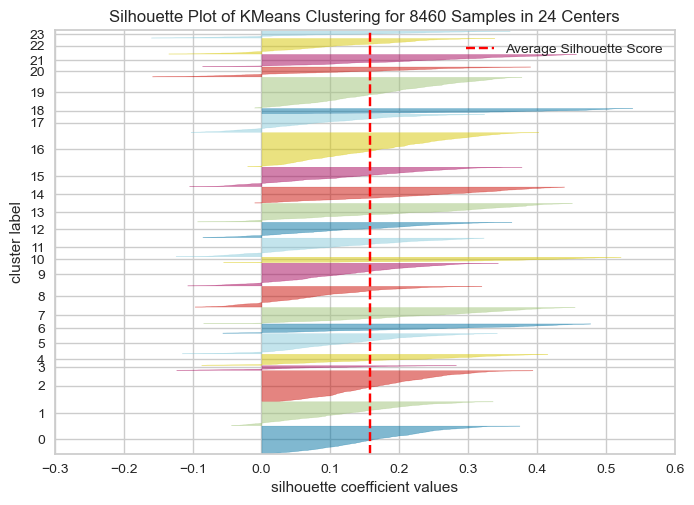

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8460 Samples in 24 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [287]:
# Yellowbrick visualization
model = KMeans(24, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

## Model 6: K17 clustering model (17 fixed clusters, 12 features, MinMax scaling)

#### Preparations & specifications

In [299]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness', 'mode', 'time_signature']]

In [300]:
# Check
X.shape

(8460, 12)

In [301]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'time_signature'}>]], dtype=object)

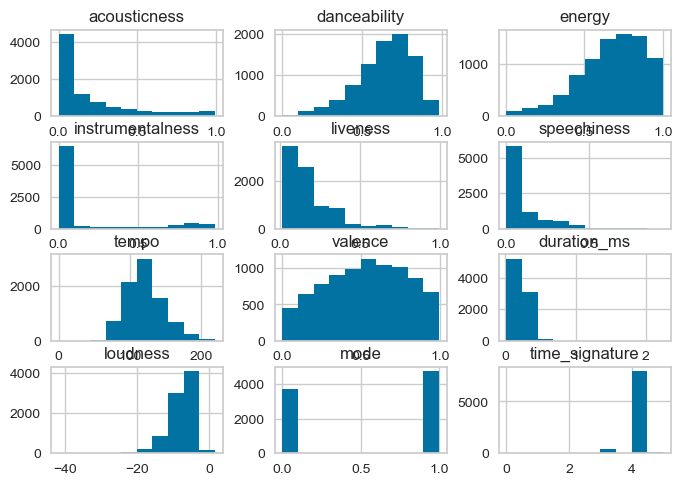

In [302]:
X.hist()

In [303]:
# Scaling model dataset (MinMaxScaler)
scaler = MinMaxScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [304]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [305]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.064724,0.845761,0.490548,0.004345,0.118038,0.029053,0.547749,0.796165,0.109446,0.737955,1.0,0.8
1,0.066734,0.756895,0.696134,0.000023,0.123148,0.029158,0.529322,0.781029,0.065677,0.800507,1.0,0.8
2,0.061307,0.586313,0.912751,0.001604,0.146653,0.140000,0.527586,0.426842,0.087308,0.851981,0.0,0.8
3,0.359799,0.554648,0.869628,0.000953,0.796627,0.045053,0.459549,0.760848,0.097167,0.812345,1.0,0.8
4,0.459296,0.538304,0.413328,0.000017,0.106796,0.128421,0.356360,0.519677,0.049975,0.698641,0.0,0.8


In [306]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000,8460.000000,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367,0.560284,3.962175
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357,0.496382,0.298931
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000,0.000000,0.000000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250,0.000000,4.000000
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000,1.000000,4.000000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000,1.000000,4.000000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000,1.000000,5.000000


#### Model building

In [307]:
# Clustering
kmeans = KMeans(n_clusters=17, random_state=42)
kmeans.fit(X_scaled)

D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=17, random_state=42)

In [308]:
# Checking result
labels = kmeans.labels_
print(labels)
print(np.unique(labels))
print(len(labels))

[1 3 0 ... 5 0 5]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
8460


In [309]:
# Predict
clusters = kmeans.predict(X_scaled)

# Check
clusters

array([1, 3, 0, ..., 5, 0, 5])

In [310]:
# Check: Counts per cluster
pd.Series(clusters).value_counts().sort_index()

0      588
1      623
2      353
3      984
4      406
5      519
6      149
7      406
8      433
9      719
10     692
11    1120
12     270
13     122
14     600
15     230
16     246
Name: count, dtype: int64

In [311]:
# Adding clusters to model and original dataframe
X['cluster'] = clusters
df["cluster"] = clusters

C:\Users\user\AppData\Local\Temp\ipykernel_8408\1697861218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


In [312]:
# Adding ID to model df
X['id'] = df['id']

C:\Users\user\AppData\Local\Temp\ipykernel_8408\2796432165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['id'] = df['id']


In [313]:
# Check (should be: 14, 20)
print(X.shape)
print(df.shape)

(8460, 14)
(8460, 20)


In [314]:
# Re-order
X = X[['id', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature', 'cluster']]

In [315]:
X

,id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4,1
1,2LawezPeJhN4AWuSB0GtAU,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4,3
2,2zYzyRzz6pRmhPzyfMEC8s,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4,0
3,0GjEhVFGZW8afUYGChu3Rr,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4,15
4,1k1Bqnv2R0uJXQN4u6LKYt,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8455,5lKpoFNmC76ZZzbdskA1um,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4,13
8456,0jv2rlqUHawLg2MRVf6ucQ,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4,2
8457,4ZUGwm85RzlaD8WLQsC0Ru,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4,5
8458,6jINk60m9xyHPVbeVih4nF,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3,0


In [316]:
df.head(10)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,playlist,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,audio_features,spotify:track:0ofHAoxe9vBkTCp2UQIavz,https://api.spotify.com/v1/tracks/0ofHAoxe9vBk...,https://api.spotify.com/v1/audio-analysis/0ofH...,257800,4,1970s.csv,1
1,2LawezPeJhN4AWuSB0GtAU,0.741,0.697,0,-7.028,1,0.0277,0.0664,0.000023,0.1330,0.774,116.109,audio_features,spotify:track:2LawezPeJhN4AWuSB0GtAU,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,https://api.spotify.com/v1/audio-analysis/2Law...,160133,4,1970s.csv,3
2,2zYzyRzz6pRmhPzyfMEC8s,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400,4,1970s.csv,0
3,0GjEhVFGZW8afUYGChu3Rr,0.543,0.870,9,-6.514,1,0.0428,0.3580,0.000939,0.7920,0.754,100.804,audio_features,spotify:track:0GjEhVFGZW8afUYGChu3Rr,https://api.spotify.com/v1/tracks/0GjEhVFGZW8a...,https://api.spotify.com/v1/audio-analysis/0GjE...,230400,4,1970s.csv,15
4,1k1Bqnv2R0uJXQN4u6LKYt,0.527,0.415,4,-11.451,0,0.1220,0.4570,0.000017,0.1170,0.515,78.169,audio_features,spotify:track:1k1Bqnv2R0uJXQN4u6LKYt,https://api.spotify.com/v1/tracks/1k1Bqnv2R0uJ...,https://api.spotify.com/v1/audio-analysis/1k1B...,125093,4,1970s.csv,16
5,1xsYj84j7hUDDnTTerGWlH,0.392,0.476,1,-7.583,1,0.0249,0.3970,0.000163,0.3090,0.234,78.031,audio_features,spotify:track:1xsYj84j7hUDDnTTerGWlH,https://api.spotify.com/v1/tracks/1xsYj84j7hUD...,https://api.spotify.com/v1/audio-analysis/1xsY...,267597,4,1970s.csv,14
6,07q0QVgO56EorrSGHC48y3,0.768,0.852,4,-6.215,1,0.0380,0.2140,0.000074,0.0723,0.867,128.373,audio_features,spotify:track:07q0QVgO56EorrSGHC48y3,https://api.spotify.com/v1/tracks/07q0QVgO56Eo...,https://api.spotify.com/v1/audio-analysis/07q0...,271240,4,1970s.csv,3
7,3gdewACMIVMEWVbyb8O9sY,0.601,0.532,10,-9.119,1,0.0286,0.4320,0.000006,0.0925,0.341,136.571,audio_features,spotify:track:3gdewACMIVMEWVbyb8O9sY,https://api.spotify.com/v1/tracks/3gdewACMIVME...,https://api.spotify.com/v1/audio-analysis/3gde...,281613,4,1970s.csv,14
8,3EYOJ48Et32uATr9ZmLnAo,0.618,0.748,0,-8.905,1,0.3580,0.0384,0.000004,0.0473,0.663,134.114,audio_features,spotify:track:3EYOJ48Et32uATr9ZmLnAo,https://api.spotify.com/v1/tracks/3EYOJ48Et32u...,https://api.spotify.com/v1/audio-analysis/3EYO...,191947,4,1970s.csv,1
9,5e9TFTbltYBg2xThimr0rU,0.545,0.670,9,-8.810,1,0.0496,0.0090,0.000822,0.0451,0.481,151.553,audio_features,spotify:track:5e9TFTbltYBg2xThimr0rU,https://api.spotify.com/v1/tracks/5e9TFTbltYBg...,https://api.spotify.com/v1/audio-analysis/5e9T...,270213,4,1970s.csv,10


In [317]:
# Save model specifications (pickle)
#def save(model, filename = “filename.pickle”):
with open('6-K17/model_scaler.pickle', "wb") as f:
    pickle.dump(scaler, f)

with open('6-K17/model_kmeans.pickle', "wb") as f:
    pickle.dump(kmeans, f)

In [319]:
# Saving dataframes
X.to_csv('6-K17/X_model.csv', index=False)
df.to_csv('6-K17/df_model.csv', index=False)

In [320]:
# (As a function)
#def save(model, filename = “filename.pickle”):
#with open(filename, "wb") as f:
#    pickle.dump(model, f)

#### Evaluation: Face validity - Clusters and predominant playlists

In [321]:
# From how many playlists are the songs in a cluster
df.groupby('cluster')[['playlist']].agg(['count','nunique'])

playlist        
           count nunique
cluster                 
0            588      60
1            623      55
2            353      33
3            984      59
4            406      52
5            519      42
6            149      18
7            406      44
8            433      55
9            719      60
10           692      55
11          1120      62
12           270      37
13           122      21
14           600      60
15           230      49
16           246      44

In [322]:
# Predominant playlists per cluster
clusters_playlists = df.groupby(['cluster', 'playlist'])[['id']].count()
clusters_playlists = clusters_playlists.groupby('cluster').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
clusters_playlists.to_csv('6-K17/clusters_playlist_investigation.csv', index=True)

# Investigation in place
cluster_of_interest = 7
clusters_playlists.reset_index(inplace=True)
clusters_playlists[clusters_playlists['cluster'] == cluster_of_interest].head(10)

,cluster,playlist,id
319,7,handpicked_berlin.csv,71
320,7,handpicked_gisbert.csv,50
321,7,handpicked_slowdown_tuesday.csv,33
322,7,best_of_folk.csv,26
323,7,1970s.csv,22
324,7,best_of-country.csv,18
325,7,best_of_pop.csv,17
326,7,handpicked_billie_eilish.csv,17
327,7,2023_best_of.csv,15
328,7,handpicked_bravo_hits.csv,13


In [323]:
# Predominant clusters per playlist
playlist_clusters = df.groupby(['playlist', 'cluster'])[['id']].count()
playlist_clusters = playlist_clusters.groupby('playlist').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
playlist_clusters.to_csv('6-K17/playlist_clusters_investigation.csv', index=True)

# Investigation in place
playlist_of_interest = 'handpicked_faber.csv'
playlist_clusters.reset_index(inplace=True)
playlist_clusters[playlist_clusters['playlist'] == playlist_of_interest].head(10)

,playlist,cluster,id
660,handpicked_faber.csv,16,21
661,handpicked_faber.csv,0,6
662,handpicked_faber.csv,7,4
663,handpicked_faber.csv,4,3
664,handpicked_faber.csv,6,3
665,handpicked_faber.csv,11,3
666,handpicked_faber.csv,9,2
667,handpicked_faber.csv,10,2
668,handpicked_faber.csv,3,1
669,handpicked_faber.csv,8,1


In [324]:
# Audio features of the clusters
cluster_features = df.groupby('cluster')[['acousticness', 'danceability', 'energy', 'instrumentalness',
'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature']].mean()
cluster_features = cluster_features.round(2)

# Export
cluster_features.to_csv('6-K17/cluster_features.csv', index=True)

# Check
cluster_features

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
cluster,,,,,,,,,,,,
0,0.05,0.50,0.82,0.04,0.23,0.08,129.67,0.37,242301.31,-5.82,0.0,3.98
1,0.12,0.78,0.62,0.01,0.15,0.22,118.39,0.56,211995.06,-7.44,1.0,4.02
2,0.07,0.61,0.69,0.78,0.16,0.06,121.73,0.24,302414.94,-9.22,1.0,3.95
3,0.09,0.70,0.80,0.02,0.16,0.08,123.59,0.81,217135.39,-6.27,1.0,3.99
4,0.47,0.72,0.64,0.01,0.18,0.19,119.87,0.71,206587.39,-7.31,0.0,4.00
5,0.07,0.66,0.71,0.77,0.15,0.06,124.12,0.37,313513.49,-8.80,0.0,3.94
6,0.82,0.32,0.20,0.83,0.13,0.04,104.60,0.16,310243.29,-19.05,1.0,3.70
7,0.76,0.52,0.32,0.03,0.18,0.08,114.59,0.34,230317.37,-12.33,1.0,3.79
8,0.50,0.70,0.62,0.01,0.16,0.12,119.75,0.72,213386.65,-7.99,1.0,3.98


D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


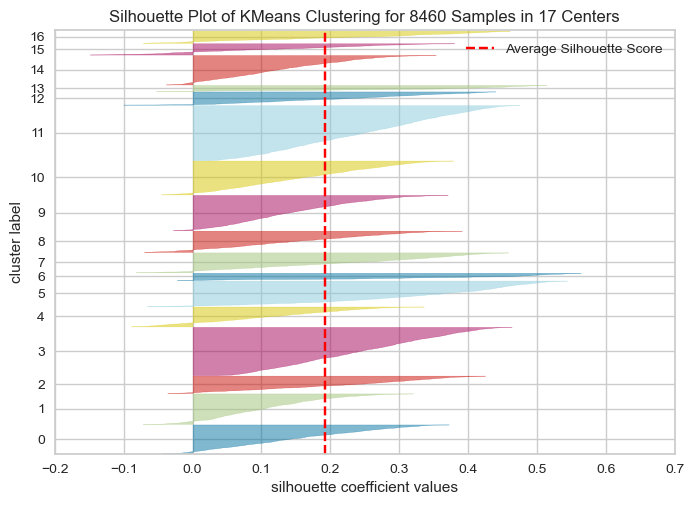

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8460 Samples in 17 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [326]:
# Yellowbrick visualization
model = KMeans(17, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

## Model 7: K17 clustering model (17 fixed clusters, 12 features, StandardScaling)

#### Preparations & specifications

In [328]:
# Specifying model dataframe X incl. mode, time_signature (maybe should be dropped later and then StandardScaler)
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'loudness', 'mode', 'time_signature']]

In [329]:
# Check
X.shape

(8460, 12)

In [330]:
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4
1,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4
2,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4
3,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4
4,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8455,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4
8456,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4
8457,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4
8458,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'time_signature'}>]], dtype=object)

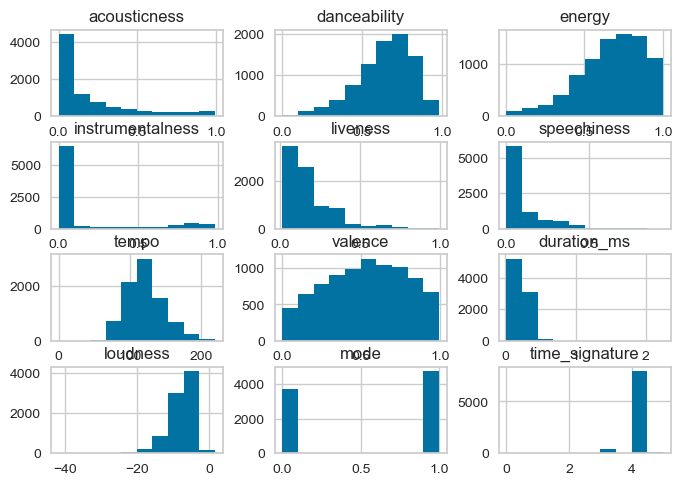

In [331]:
X.hist()

In [332]:
# Scaling model dataset (MinMaxScaler)
scaler = StandardScaler()
scaler.fit(X) # To get the fitted scaler
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [333]:
# Scaling model dataset (StandardScaler)
#scaler = StandardScaler()
#scaler.fit(X) # To get the fitted scaler
#X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [334]:
# Check
X_scaled.head()
#X_scaled.shape

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
0,-0.541403,1.085934,-0.874484,-0.493573,-0.377564,-0.712767,-0.053361,1.036994,0.254225,-0.498341,0.885895,0.126542
1,-0.533636,0.575176,0.118923,-0.508038,-0.343772,-0.711869,-0.204100,0.977991,-0.885279,0.202359,0.885895,0.126542
2,-0.554606,-0.405244,1.165634,-0.502747,-0.188331,0.234077,-0.218309,-0.402682,-0.322136,0.778965,-1.128802,0.126542
3,0.598731,-0.587238,0.957261,-0.504925,4.109962,-0.576220,-0.774874,0.899320,-0.065457,0.334965,0.885895,0.126542
4,0.983176,-0.681171,-1.247618,-0.508057,-0.451905,0.135260,-1.619007,-0.040796,-1.294099,-0.938729,-1.128802,0.126542


In [335]:
X.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
count,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8460.000000,8.460000e+03,8460.000000,8460.000000,8460.000000
mean,0.203819,0.643027,0.672459,0.149547,0.183866,0.106943,121.581835,0.525371,2.360104e+05,-7.812367,0.560284,3.962175
std,0.257529,0.170345,0.206373,0.294335,0.147974,0.111324,26.816068,0.254239,8.571518e+04,3.876357,0.496382,0.298931
min,0.000000,0.000000,0.002850,0.000000,0.012500,0.000000,0.000000,0.000000,1.357800e+04,-41.786000,0.000000,0.000000
25%,0.014900,0.544000,0.544000,0.000000,0.091900,0.038500,100.093750,0.327000,1.873890e+05,-9.402250,0.000000,4.000000
50%,0.088000,0.668000,0.700000,0.000083,0.123000,0.056400,122.009000,0.536000,2.204200e+05,-7.001000,1.000000,4.000000
75%,0.295250,0.771000,0.834000,0.061700,0.238000,0.123000,137.054500,0.734000,2.630302e+05,-5.244000,1.000000,4.000000
max,0.995000,0.979000,1.000000,0.985000,0.991000,0.950000,219.354000,0.991000,2.245013e+06,1.634000,1.000000,5.000000


#### Model building

In [336]:
# Clustering
kmeans = KMeans(n_clusters=17, random_state=42)
kmeans.fit(X_scaled)

D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=17, random_state=42)

In [337]:
# Checking result
labels = kmeans.labels_
print(labels)
print(np.unique(labels))
print(len(labels))

[10 13  6 ...  8 14  8]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
8460


In [338]:
# Predict
clusters = kmeans.predict(X_scaled)

# Check
clusters

array([10, 13,  6, ...,  8, 14,  8])

In [339]:
# Check: Counts per cluster
pd.Series(clusters).value_counts().sort_index()

0      531
1      789
2      497
3      216
4      651
5      374
6      634
7      526
8      854
9      732
10     637
11     534
12      29
13    1038
14     270
15      35
16     113
Name: count, dtype: int64

In [340]:
# Adding clusters to model and original dataframe
X['cluster'] = clusters
df["cluster"] = clusters

C:\Users\user\AppData\Local\Temp\ipykernel_8408\1697861218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = clusters


In [341]:
# Adding ID to model df
X['id'] = df['id']

C:\Users\user\AppData\Local\Temp\ipykernel_8408\2796432165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['id'] = df['id']


In [342]:
# Check (should be: 14, 20)
print(X.shape)
print(df.shape)

(8460, 14)
(8460, 20)


In [343]:
# Re-order
X = X[['id', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature', 'cluster']]

In [344]:
X

,id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.06440,0.828,0.492,0.004280,0.1280,0.0276,120.151,0.7890,257800,-9.744,1,4,10
1,2LawezPeJhN4AWuSB0GtAU,0.06640,0.741,0.697,0.000023,0.1330,0.0277,116.109,0.7740,160133,-7.028,1,4,13
2,2zYzyRzz6pRmhPzyfMEC8s,0.06100,0.574,0.913,0.001580,0.1560,0.1330,115.728,0.4230,208400,-4.793,0,4,6
3,0GjEhVFGZW8afUYGChu3Rr,0.35800,0.543,0.870,0.000939,0.7920,0.0428,100.804,0.7540,230400,-6.514,1,4,5
4,1k1Bqnv2R0uJXQN4u6LKYt,0.45700,0.527,0.415,0.000017,0.1170,0.1220,78.169,0.5150,125093,-11.451,0,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8455,5lKpoFNmC76ZZzbdskA1um,0.35300,0.267,0.201,0.826000,0.1500,0.0389,120.038,0.0346,292000,-15.386,0,4,3
8456,0jv2rlqUHawLg2MRVf6ucQ,0.00870,0.762,0.739,0.888000,0.0987,0.0594,126.024,0.0379,565127,-9.094,1,4,8
8457,4ZUGwm85RzlaD8WLQsC0Ru,0.00108,0.715,0.727,0.853000,0.0978,0.0377,127.993,0.2250,517500,-7.104,0,4,8
8458,6jINk60m9xyHPVbeVih4nF,0.00218,0.547,0.701,0.202000,0.1070,0.0416,125.983,0.2080,232381,-7.969,0,3,14


In [345]:
df.head(10)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,playlist,cluster
0,0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,audio_features,spotify:track:0ofHAoxe9vBkTCp2UQIavz,https://api.spotify.com/v1/tracks/0ofHAoxe9vBk...,https://api.spotify.com/v1/audio-analysis/0ofH...,257800,4,1970s.csv,10
1,2LawezPeJhN4AWuSB0GtAU,0.741,0.697,0,-7.028,1,0.0277,0.0664,0.000023,0.1330,0.774,116.109,audio_features,spotify:track:2LawezPeJhN4AWuSB0GtAU,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,https://api.spotify.com/v1/audio-analysis/2Law...,160133,4,1970s.csv,13
2,2zYzyRzz6pRmhPzyfMEC8s,0.574,0.913,6,-4.793,0,0.1330,0.0610,0.001580,0.1560,0.423,115.728,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,https://api.spotify.com/v1/audio-analysis/2zYz...,208400,4,1970s.csv,6
3,0GjEhVFGZW8afUYGChu3Rr,0.543,0.870,9,-6.514,1,0.0428,0.3580,0.000939,0.7920,0.754,100.804,audio_features,spotify:track:0GjEhVFGZW8afUYGChu3Rr,https://api.spotify.com/v1/tracks/0GjEhVFGZW8a...,https://api.spotify.com/v1/audio-analysis/0GjE...,230400,4,1970s.csv,5
4,1k1Bqnv2R0uJXQN4u6LKYt,0.527,0.415,4,-11.451,0,0.1220,0.4570,0.000017,0.1170,0.515,78.169,audio_features,spotify:track:1k1Bqnv2R0uJXQN4u6LKYt,https://api.spotify.com/v1/tracks/1k1Bqnv2R0uJ...,https://api.spotify.com/v1/audio-analysis/1k1B...,125093,4,1970s.csv,7
5,1xsYj84j7hUDDnTTerGWlH,0.392,0.476,1,-7.583,1,0.0249,0.3970,0.000163,0.3090,0.234,78.031,audio_features,spotify:track:1xsYj84j7hUDDnTTerGWlH,https://api.spotify.com/v1/tracks/1xsYj84j7hUD...,https://api.spotify.com/v1/audio-analysis/1xsY...,267597,4,1970s.csv,9
6,07q0QVgO56EorrSGHC48y3,0.768,0.852,4,-6.215,1,0.0380,0.2140,0.000074,0.0723,0.867,128.373,audio_features,spotify:track:07q0QVgO56EorrSGHC48y3,https://api.spotify.com/v1/tracks/07q0QVgO56Eo...,https://api.spotify.com/v1/audio-analysis/07q0...,271240,4,1970s.csv,13
7,3gdewACMIVMEWVbyb8O9sY,0.601,0.532,10,-9.119,1,0.0286,0.4320,0.000006,0.0925,0.341,136.571,audio_features,spotify:track:3gdewACMIVMEWVbyb8O9sY,https://api.spotify.com/v1/tracks/3gdewACMIVME...,https://api.spotify.com/v1/audio-analysis/3gde...,281613,4,1970s.csv,9
8,3EYOJ48Et32uATr9ZmLnAo,0.618,0.748,0,-8.905,1,0.3580,0.0384,0.000004,0.0473,0.663,134.114,audio_features,spotify:track:3EYOJ48Et32uATr9ZmLnAo,https://api.spotify.com/v1/tracks/3EYOJ48Et32u...,https://api.spotify.com/v1/audio-analysis/3EYO...,191947,4,1970s.csv,11
9,5e9TFTbltYBg2xThimr0rU,0.545,0.670,9,-8.810,1,0.0496,0.0090,0.000822,0.0451,0.481,151.553,audio_features,spotify:track:5e9TFTbltYBg2xThimr0rU,https://api.spotify.com/v1/tracks/5e9TFTbltYBg...,https://api.spotify.com/v1/audio-analysis/5e9T...,270213,4,1970s.csv,0


In [347]:
# Save model specifications (pickle)
#def save(model, filename = “filename.pickle”):
with open('7-K17/model_scaler.pickle', "wb") as f:
    pickle.dump(scaler, f)

with open('7-K17/model_kmeans.pickle', "wb") as f:
    pickle.dump(kmeans, f)

In [348]:
# Saving dataframes
X.to_csv('7-K17/X_model.csv', index=False)
df.to_csv('7-K17/df_model.csv', index=False)

In [349]:
# (As a function)
#def save(model, filename = “filename.pickle”):
#with open(filename, "wb") as f:
#    pickle.dump(model, f)

#### Evaluation: Face validity - Clusters and predominant playlists

In [350]:
# From how many playlists are the songs in a cluster
df.groupby('cluster')[['playlist']].agg(['count','nunique'])

playlist        
           count nunique
cluster                 
0            531      53
1            789      60
2            497      38
3            216      21
4            651      58
5            374      59
6            634      60
7            526      48
8            854      42
9            732      60
10           637      63
11           534      41
12            29      19
13          1038      59
14           270      53
15            35       8
16           113      25

In [351]:
# Predominant playlists per cluster
clusters_playlists = df.groupby(['cluster', 'playlist'])[['id']].count()
clusters_playlists = clusters_playlists.groupby('cluster').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
clusters_playlists.to_csv('7-K17/clusters_playlist_investigation.csv', index=True)

# Investigation in place
cluster_of_interest = 7
clusters_playlists.reset_index(inplace=True)
clusters_playlists[clusters_playlists['cluster'] == cluster_of_interest].head(10)

,cluster,playlist,id
349,7,handpicked_berlin.csv,72
350,7,handpicked_gisbert.csv,55
351,7,handpicked_slowdown_tuesday.csv,46
352,7,best_of_folk.csv,32
353,7,1970s.csv,30
354,7,handpicked_billie_eilish.csv,27
355,7,best_of_world.csv,20
356,7,best_of-blues.csv,19
357,7,handpicked_faber.csv,19
358,7,handpicked_bravo_hits.csv,15


In [352]:
# Predominant clusters per playlist
playlist_clusters = df.groupby(['playlist', 'cluster'])[['id']].count()
playlist_clusters = playlist_clusters.groupby('playlist').apply(lambda x: x.sort_values(by='id', ascending=False)).reset_index(level=0, drop=True)

# Export
playlist_clusters.to_csv('7-K17/playlist_clusters_investigation.csv', index=True)

# Investigation in place
playlist_of_interest = 'handpicked_faber.csv'
playlist_clusters.reset_index(inplace=True)
playlist_clusters[playlist_clusters['playlist'] == playlist_of_interest].head(10)

,playlist,cluster,id
632,handpicked_faber.csv,7,19
633,handpicked_faber.csv,6,12
634,handpicked_faber.csv,14,6
635,handpicked_faber.csv,3,3
636,handpicked_faber.csv,0,2
637,handpicked_faber.csv,1,2
638,handpicked_faber.csv,9,1
639,handpicked_faber.csv,10,1
640,handpicked_faber.csv,13,1


In [353]:
# Audio features of the clusters
cluster_features = df.groupby('cluster')[['acousticness', 'danceability', 'energy', 'instrumentalness',
'liveness', 'speechiness', 'tempo', 'valence', 'duration_ms',
       'loudness', 'mode', 'time_signature']].mean()
cluster_features = cluster_features.round(2)

# Export
cluster_features.to_csv('7-K17/cluster_features.csv', index=True)

# Check
cluster_features

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_ms,loudness,mode,time_signature
cluster,,,,,,,,,,,,
0,0.09,0.44,0.81,0.08,0.19,0.09,168.08,0.48,233366.50,-6.00,0.75,4.00
1,0.18,0.78,0.67,0.03,0.13,0.09,109.01,0.70,217858.59,-6.88,0.00,4.00
2,0.24,0.74,0.63,0.01,0.16,0.34,123.00,0.55,193973.27,-7.54,0.00,3.99
3,0.79,0.30,0.19,0.79,0.13,0.04,102.82,0.15,237038.01,-19.28,0.62,3.77
4,0.07,0.67,0.84,0.07,0.19,0.07,133.78,0.72,219188.26,-5.82,0.00,4.00
5,0.18,0.63,0.75,0.08,0.67,0.12,120.02,0.59,236101.13,-6.85,0.61,3.99
6,0.11,0.57,0.71,0.05,0.18,0.06,114.36,0.32,240857.68,-6.71,0.00,4.00
7,0.74,0.55,0.34,0.07,0.15,0.06,114.12,0.37,225217.45,-12.24,0.65,4.02
8,0.07,0.67,0.69,0.79,0.14,0.06,122.34,0.36,329355.41,-9.24,0.51,3.99


D:\ANALYTICS\_Software\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


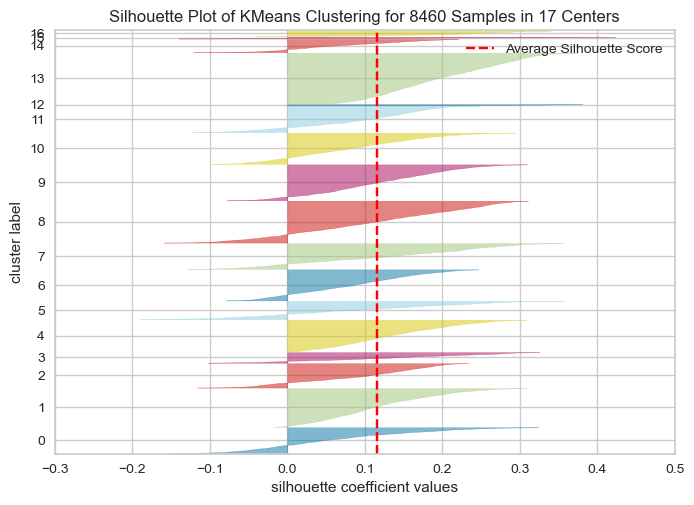

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8460 Samples in 17 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [354]:
# Yellowbrick visualization
model = KMeans(17, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()